<a href="https://colab.research.google.com/github/lukaszplust/NUMERICAL_METHODS/blob/main/Interpolation_MN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import lu_factor, lu_solve

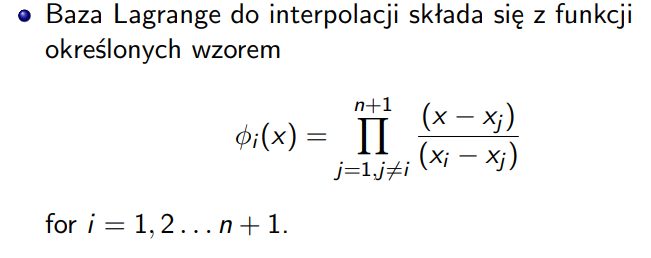

In [2]:
def lagrange_interpolate(point_x,point_y,x):
  value_interpolated = 0
  n = len(point_x)
  for i in range(n):
    fi = 1
    for j in range(n):
      if i != j:
        fi *= (x - point_x[j]) / (point_x[i] - point_x[j]) #tu może jeszcze powinno być 1.0 * przed nawiasem
    value_interpolated += (fi * point_y[i])
  return value_interpolated

In [3]:
def lagrange(value_x, point_x, point_y):
    return [lagrange_interpolate(point_x, point_y, x) for x in value_x]

Wykres

In [4]:
#value_x, value_y -> input_x, input_y, point_x, point_y -> node_x, node_y
def plot_lagrange(value_x, value_y, point_x, point_y, interpolated_x, interpolated_y):
  plt.yscale('log')
  plt.plot(value_x, value_y, '-',color ='blue', label = 'samples')#
  plt.plot(interpolated_x,interpolated_y, color ='green',label = "F(x) interpoled")#funkcja interpolujaca
  plt.plot(point_x, point_y,'o',color ='orange',label = 'nodes')#wezly

  plt.title(f"Lagrange_Interpolation for: {str(len(point_x))} nodes")
  plt.xlabel('distance [m]')
  plt.ylabel('height [m.n.p.m]')
  plt.legend()

  save_name = "Lagrange_Interpolation for "
  save_name += str(len(point_x))
  save_name += " nodes"
  plt.savefig(f"{save_name}.png")

  plt.show()
  

Przygotowanie danych

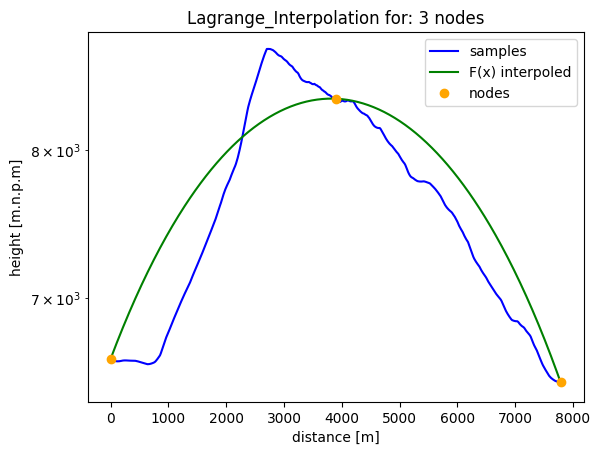

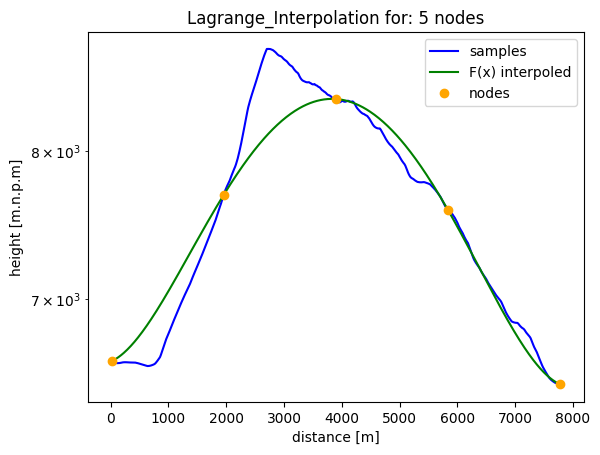

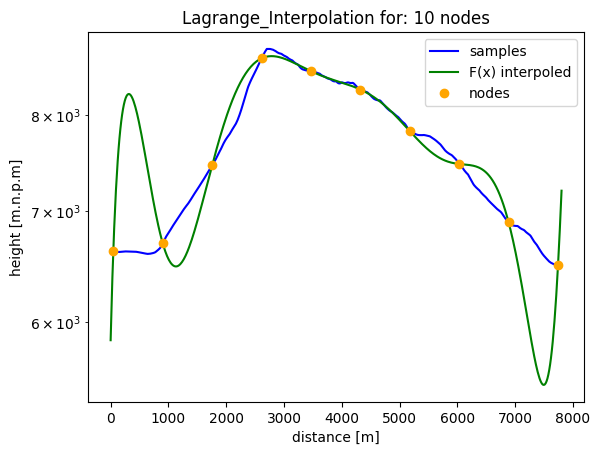

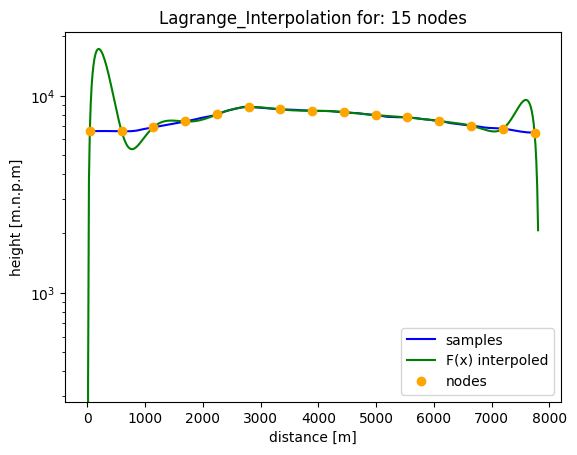

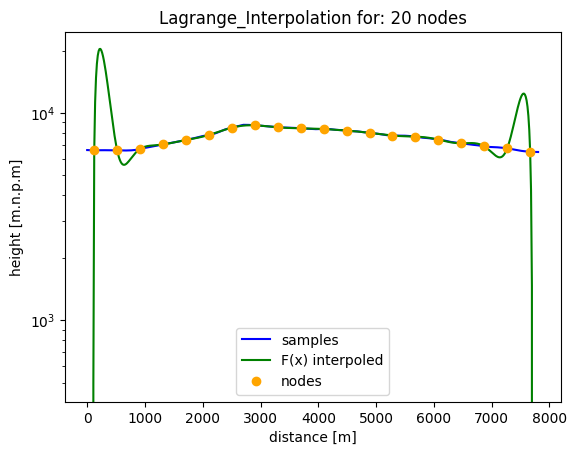

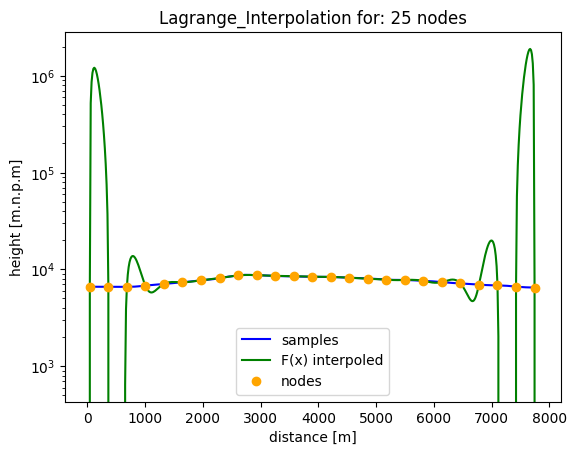

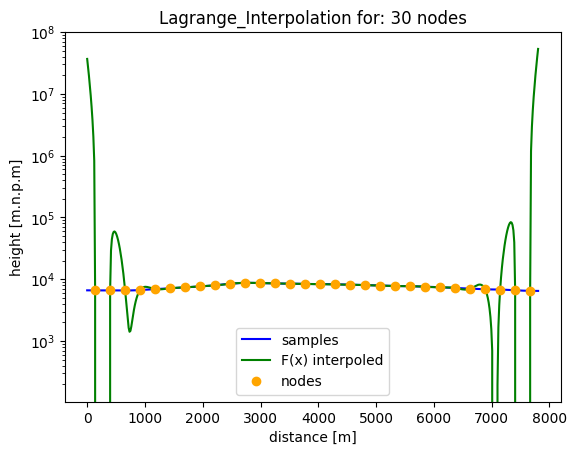

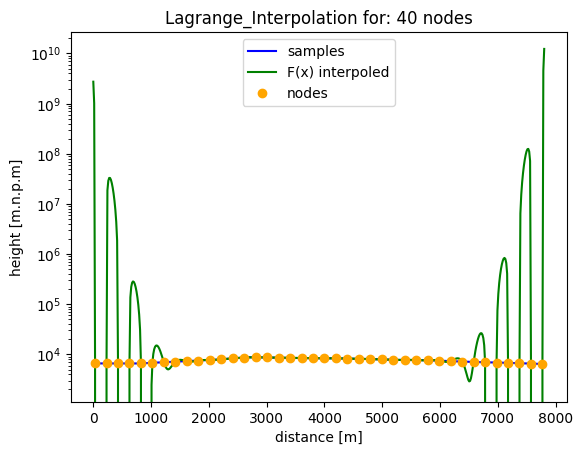

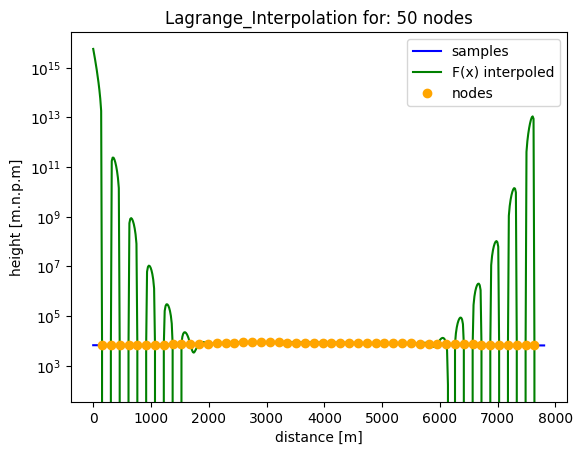

In [5]:
df = pd.read_csv('MountEverest.csv')
size = df.shape[0]# len(df.index), sample_size
nodes = [3,5,10,15,20,25,30,40,50]

for node in nodes:
  intervals = node - 1# interwal liczba - 1
  x = 1
  while intervals * (x + 1) < size:
    x += 1
  first_node = 0#zmienic na y
  while (first_node + 1) < (size - 1 - (first_node + intervals*x)):
    first_node += 1
  x_index = [first_node]
  for i in range(1, node):
    x_index.append(first_node + i * x)


  value_distance = df.iloc[:, 0].tolist()  # input distance
  value_height = df.iloc[:, 1].tolist()  # input height

  nodes_distance = []
  nodes_height = []

  for i in x_index:
    nodes_distance.append(value_distance[i])
    nodes_height.append(value_height[i])

  interpolated_lagrange = lagrange(value_distance, nodes_distance, nodes_height)
  plot_lagrange(value_distance,value_height,nodes_distance, nodes_height,value_distance,interpolated_lagrange)

Skeljny

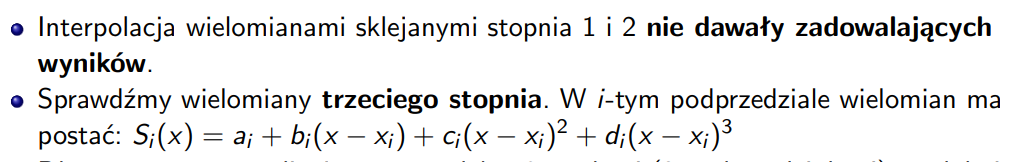

In [35]:
def interpolation_spline(points, params, x):
    for i in range(len(points)-1):
        xi = points[i][0]
        xj = points[i + 1][0]
        if xi <= x < xj:
            a, b, c, d = params[i]
            h = x - xi
            return a + b * h + c * (h ** 2) + d * (h ** 3)
    return -9999

In [36]:
def spline(point_x):
  for i in range(0,len(point_x)-1):
    h = point_x[i+1] - point_x[i]# h = xi+1 − xi

In [37]:
import pdb

def params(data):
  #len_data = len(data)
  params = []
  for i in range(len(data)):
        params.append([0, 0, 0, 0])
  #params = np.zeros((1,len_data))
  
  h = data[1][0] - data[0][0]# x1 - x0

  for i in range(len(data) - 2):
    matrix = []

    y0 = data[i][1]
    y1 = data[i+1][1]
    y2 = data[i+2][1]

    # a0 = f (x0)
    row = [1, 0, 0, 0, 0, 0, 0, 0]
    matrix.append(row)
    # a1 = f (x1)
    row = [0, 0, 0, 0, 1, 0, 0, 0]
    matrix.append(row)
    # a0 + b0h + c0h^2 + d0h^3 = f (x1)
    row = [1, h, h ** 2, h ** 3, 0, 0, 0, 0]
    matrix.append(row)
    # a1 + b1h + c1h^2 + d1h^3 = f (x2)
    row = [0, 0, 0, 0, 1, h, h ** 2, h ** 3]
    matrix.append(row)
    # b0 + 2c0h + 3d0h^2 - b1 = 0
    row = [0, 1, 2 * h, 3 * (h ** 2), 0, -1, 0, 0]
    matrix.append(row)
    # 2c0 + 6d0h - 2c1 = 0
    row = [0, 0, 2, 6 * h, 0, 0, -2, 0]
    matrix.append(row)
    # c0 = 0
    row = [0, 0, 1, 0, 0, 0, 0, 0]
    matrix.append(row)
    # 2c1 + 6d1h = 0
    row = [0, 0, 0, 0, 0, 0, 2, 6 * h]
    matrix.append(row)

    values = [y0, y1, y1, y2, 0, 0, 0, 0]
    lu, piv = lu_factor(matrix)
    
    [a0, b0, c0, d0, a1, b1, c1, d1] = lu_solve((lu, piv), values)#wywoalac lu

    params[i] = [a0, b0, c0, d0]#ogarnac
    params[i + 1] = [a1, b1, c1, d1]#ogarnac

  return params

Przygotowanie danych do splejnow

In [38]:
def data_to_spline(n):

  #przygotowanie danych
  df = pd.read_csv('MountEverest.csv')
  #data = df
  df = df.values.tolist()
  df = df[1::]#wszystkie wiersze oprocz pierwszego
  data = []
  for i in range(len(df)):
    data.append([i, float(df[i][1])])#i->dystans, float(df[i][1])->wysokosc
  data_co_n = data[::n]#biore co n element
  #data_co_n -> [dystans,wysokosci], co n 

  parameters = params(data_co_n)

  param_x = []#dystans
  param_y = []#wysokosc
  interpolated_y = []
  #data -> [odleglosc,wwysokosc] -> 13 -n = 10
  for i in range(len(data)):#ewnentualnie odjac -n
    x, y = data[i]

    param_x.append(x)
    param_y.append(y)
    interpolated_y.append(interpolation_spline(data_co_n, parameters, x))#ogarnac jeszcze

    plt.plot(param_x, param_y, color = 'blue', label = 'dane z pliku')
    plt.plot(param_x, interpolated_y, color='red', label = 'dane interpolowane')
    plt.legend()
    plt.title('Interpolacja splajnami, dla danych z co ' + str(n) + '-tym pomiarem,' + str(len(data_co_n))+' punktow')
    #plt.suptitle('plik: '+ file)
    plt.ylabel('Wysokość')
    plt.xlabel('Odległość')
    plt.show()
    plt.savefig('-spline_with_n_'+str(n)+'.png')

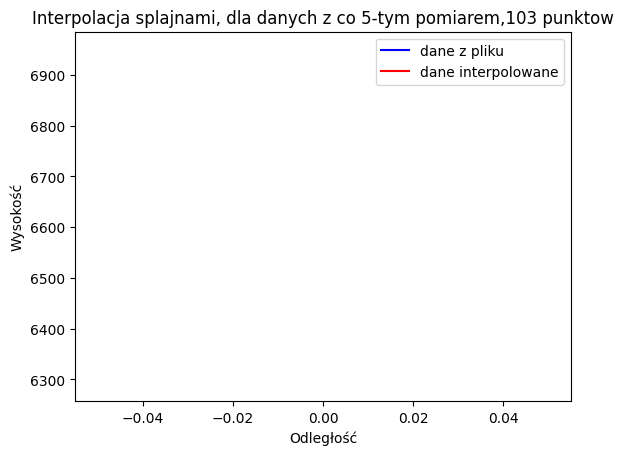

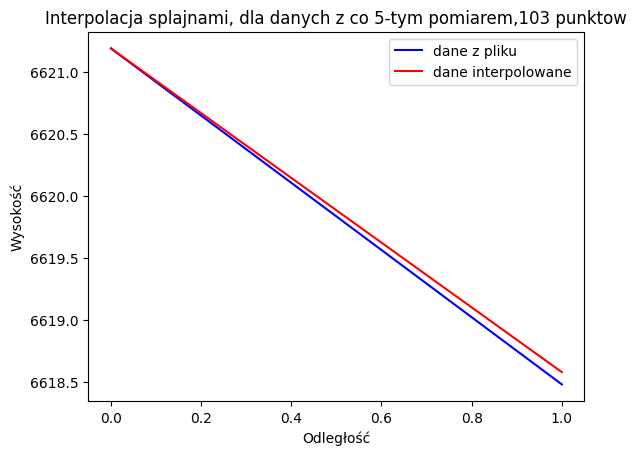

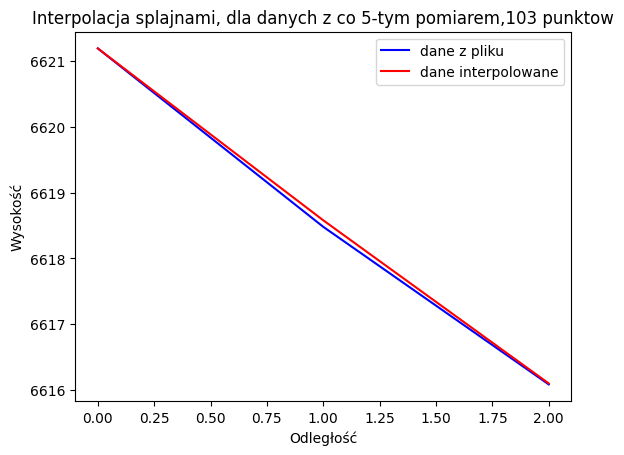

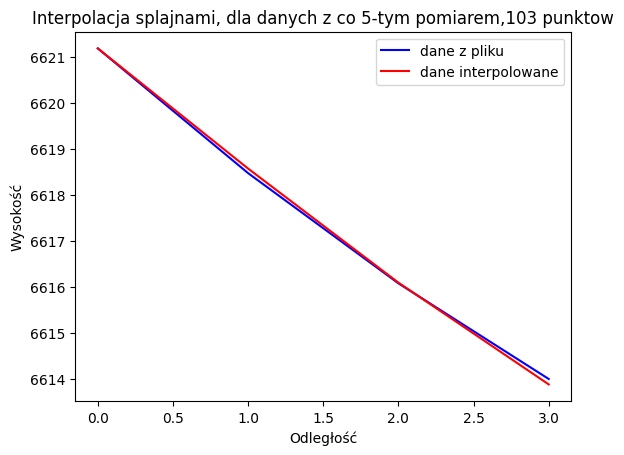

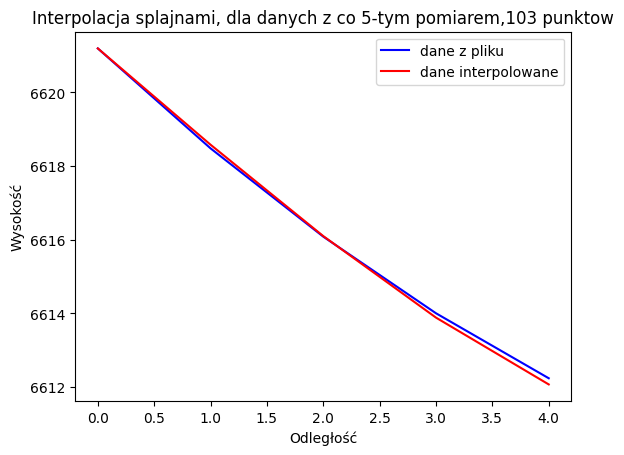

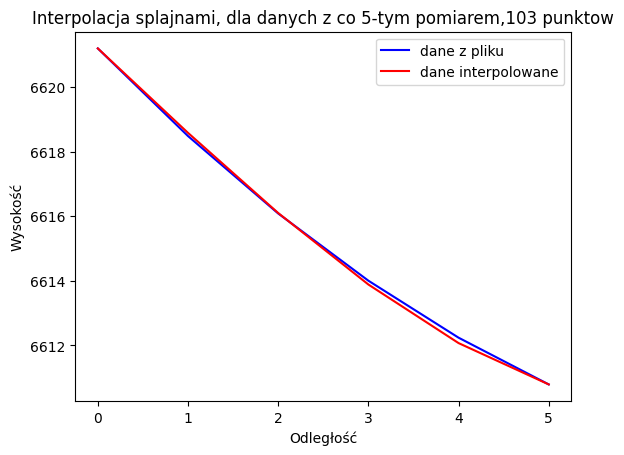

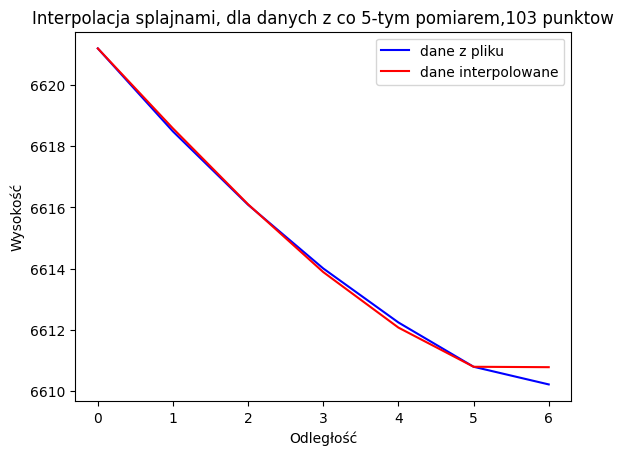

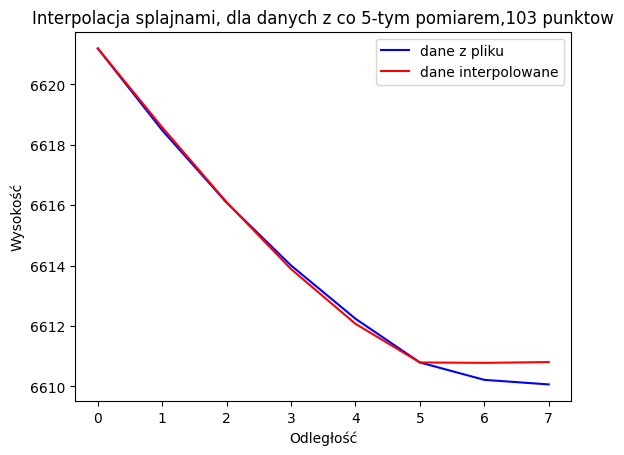

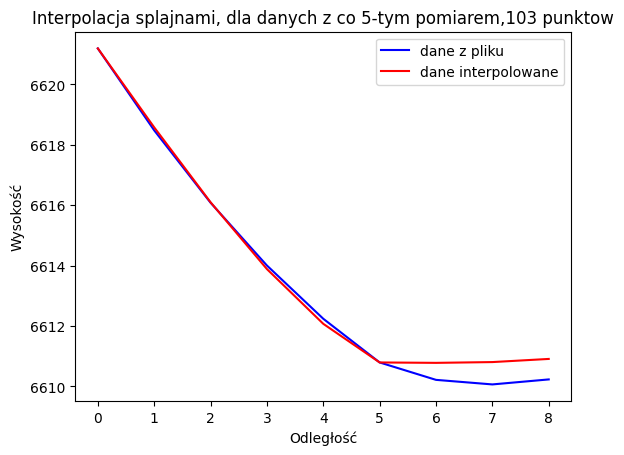

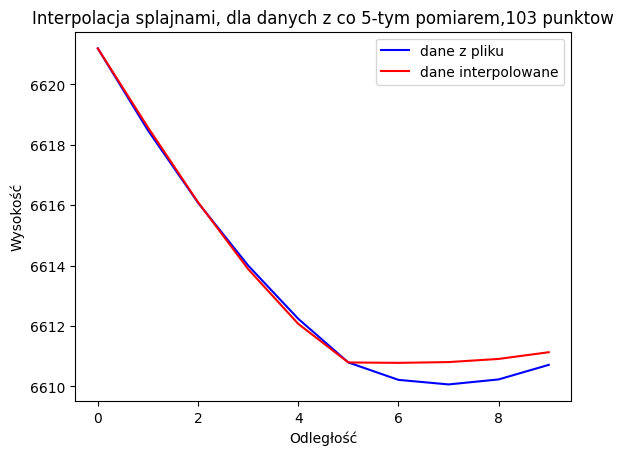

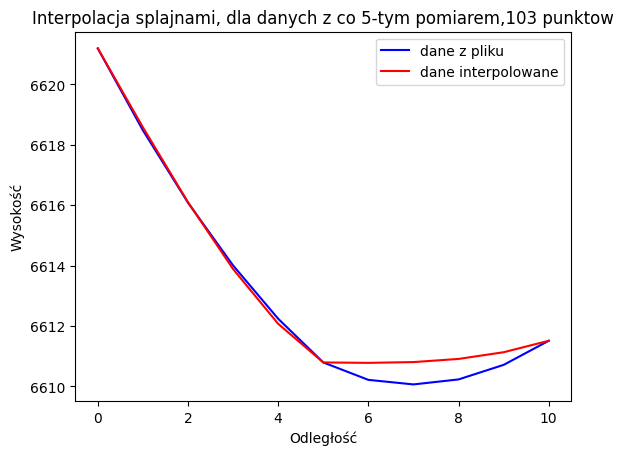

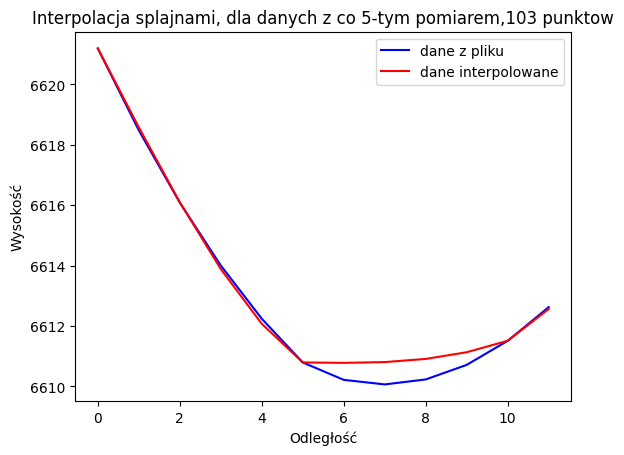

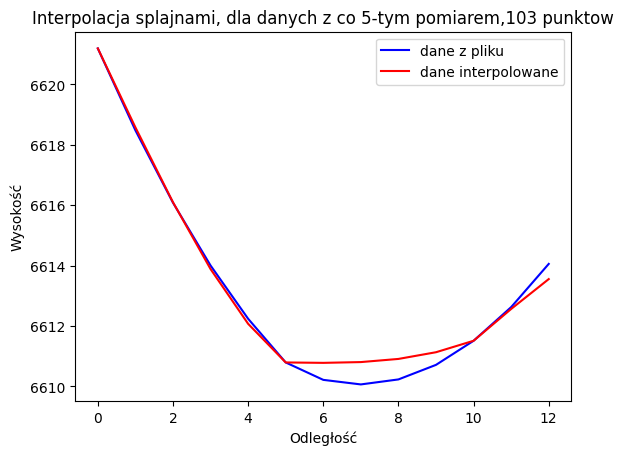

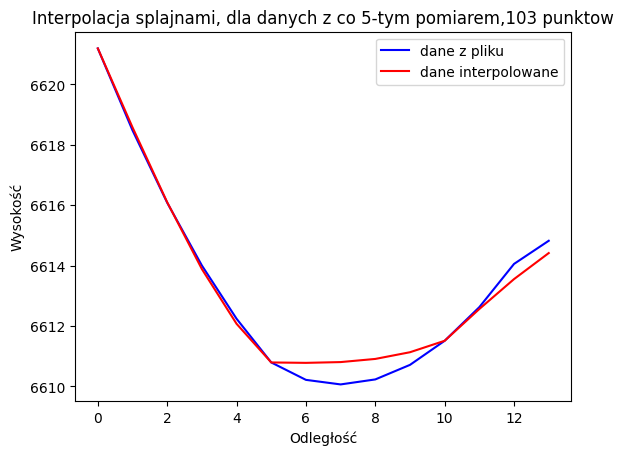

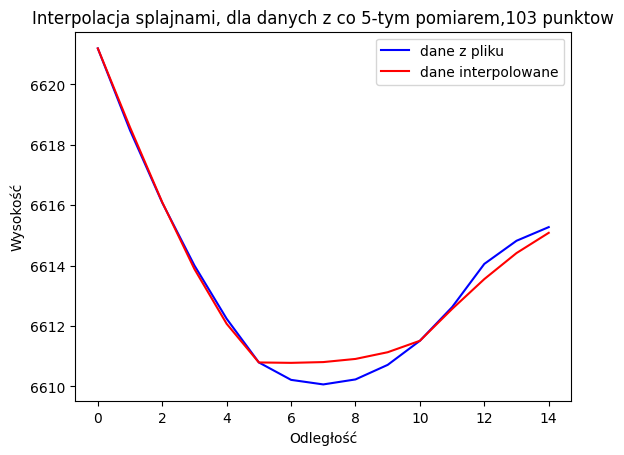

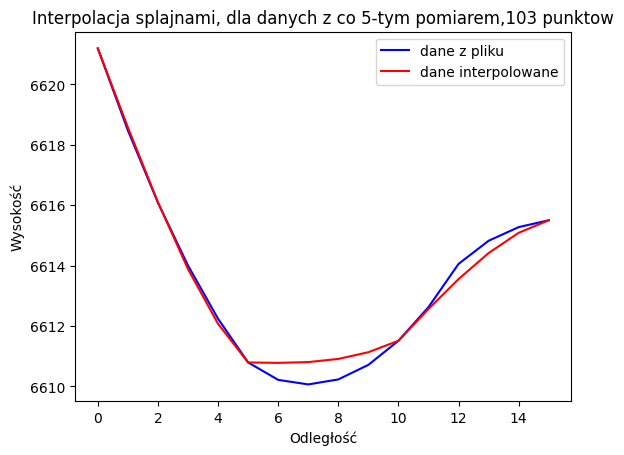

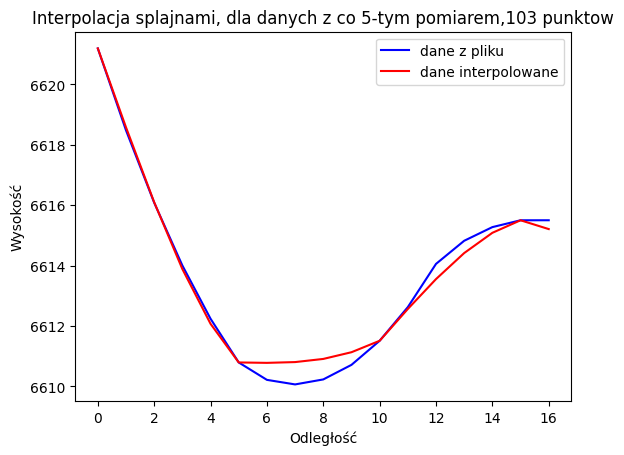

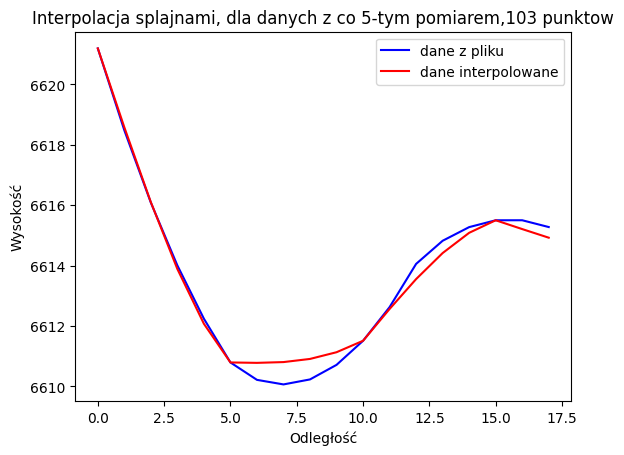

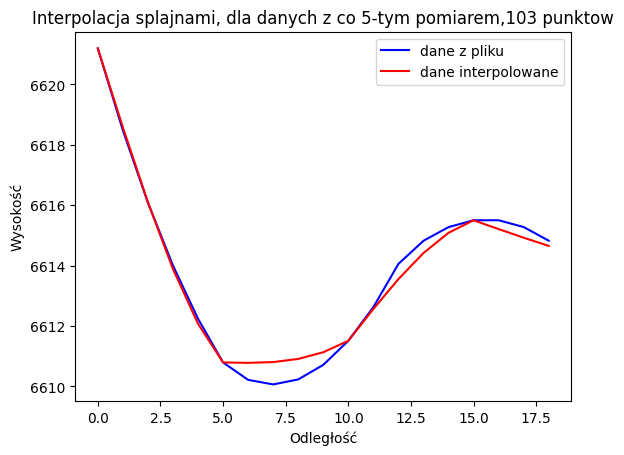

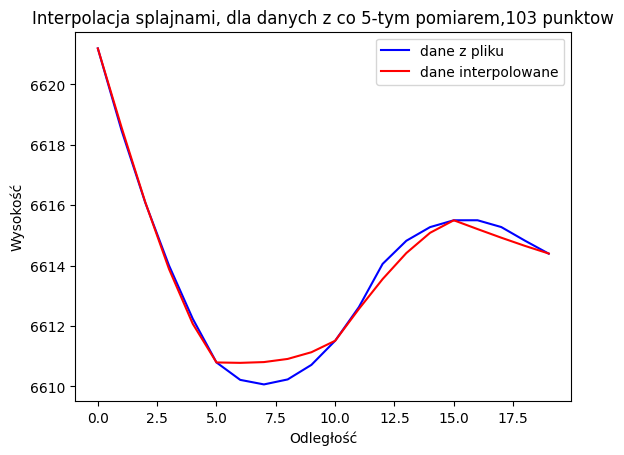

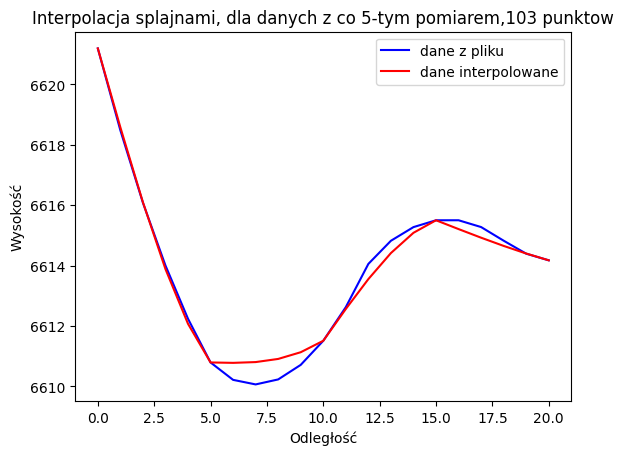

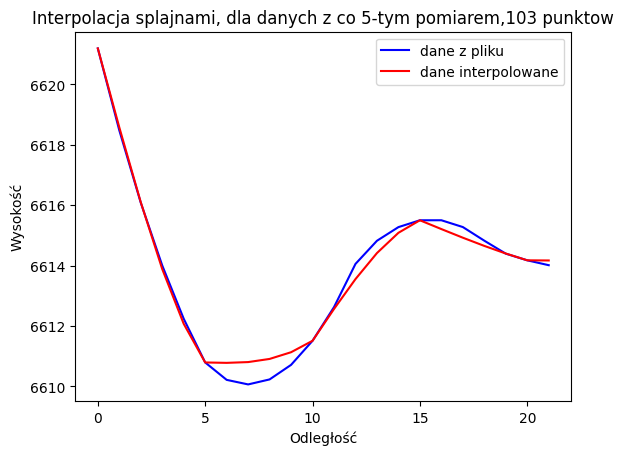

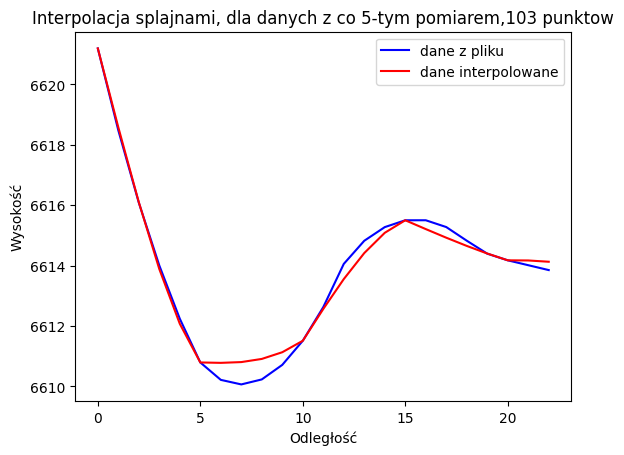

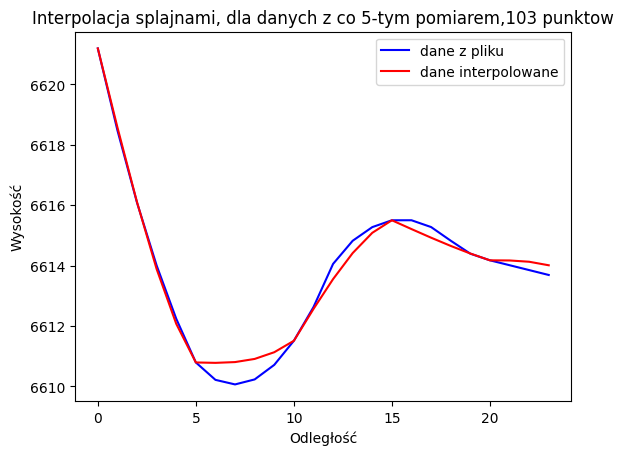

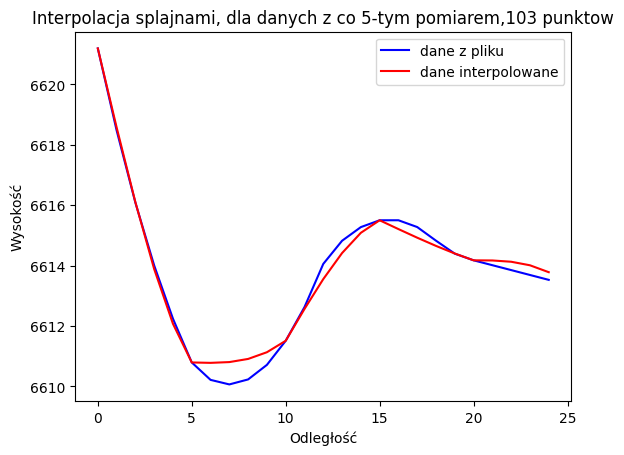

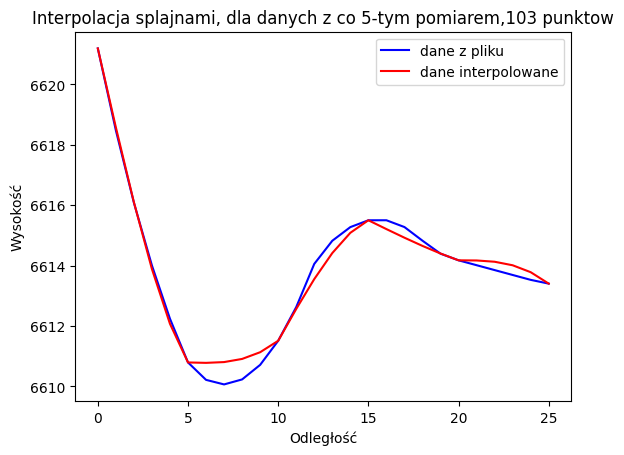

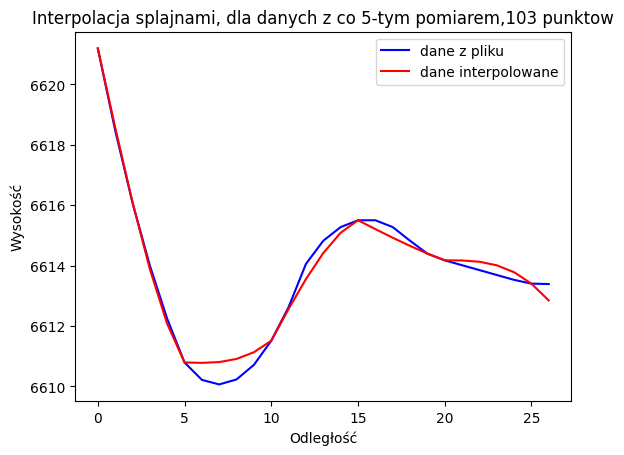

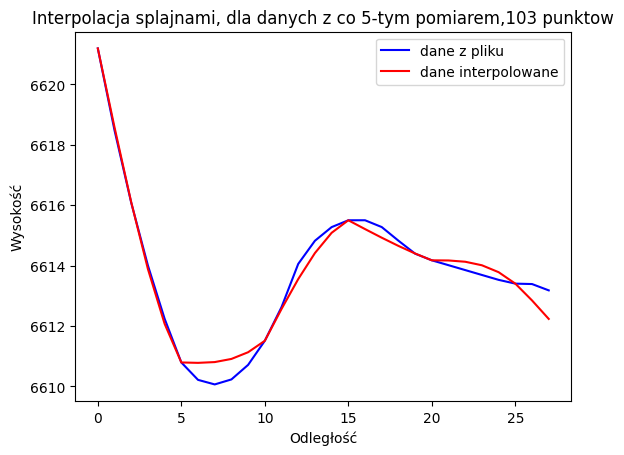

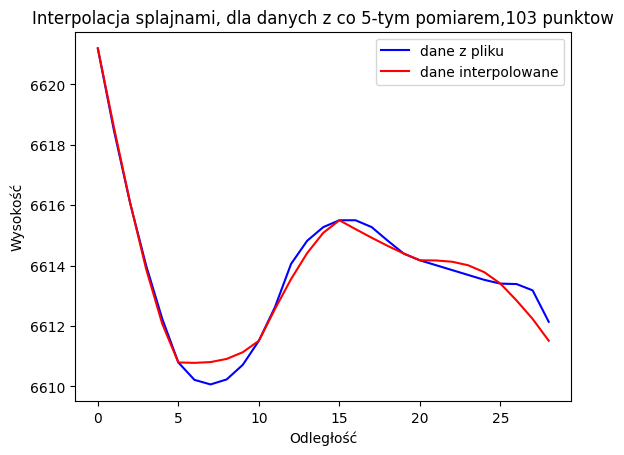

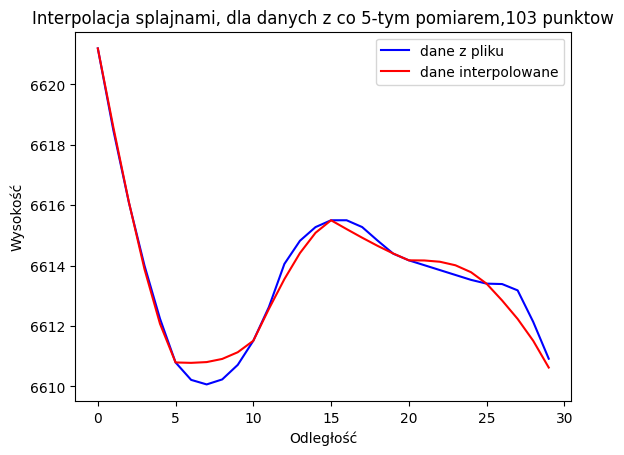

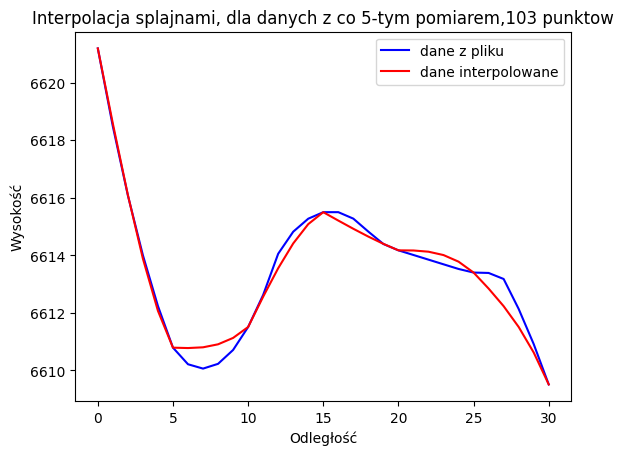

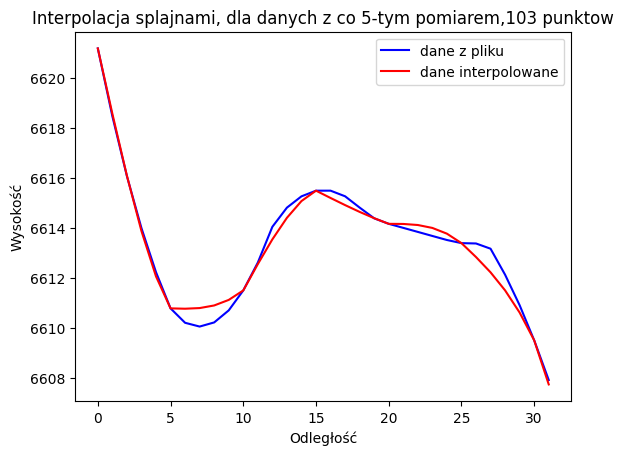

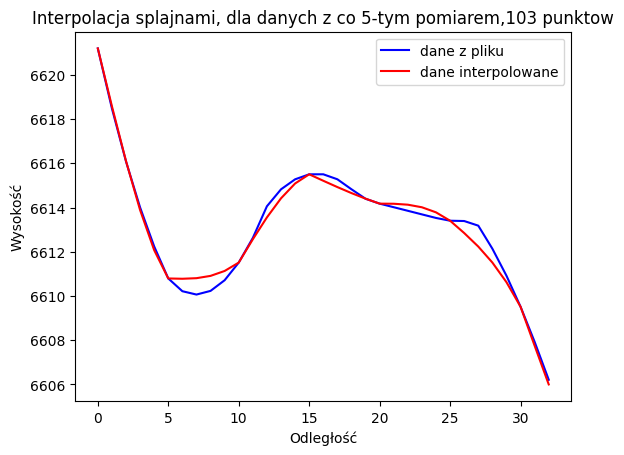

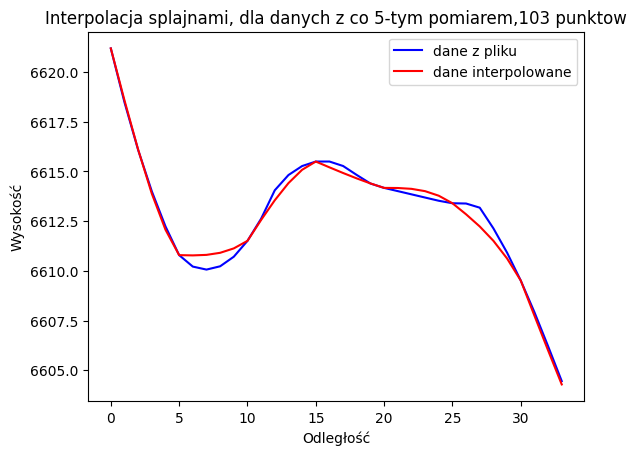

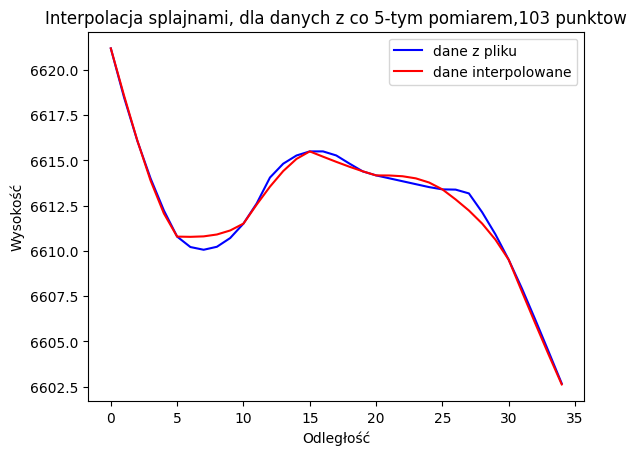

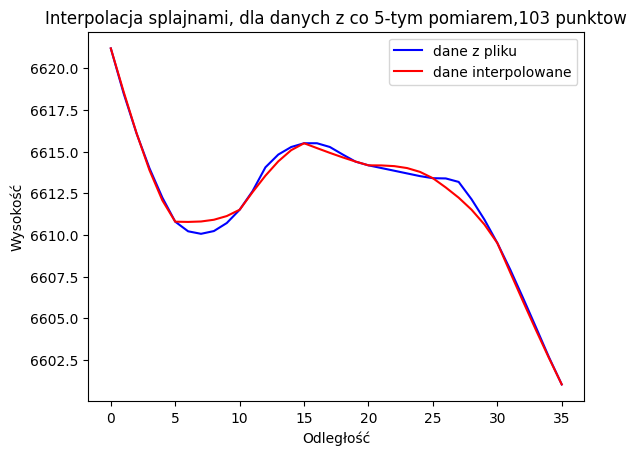

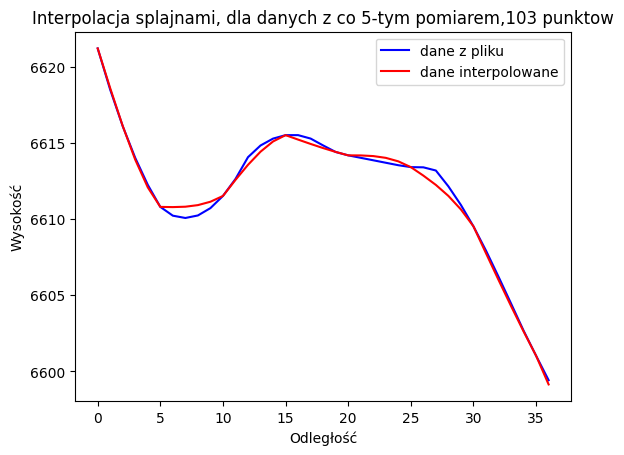

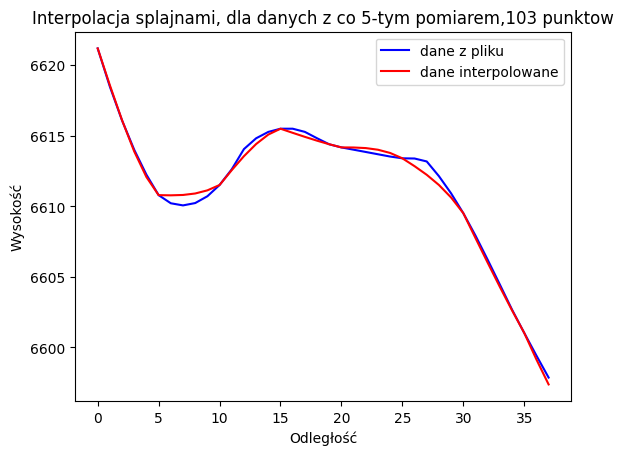

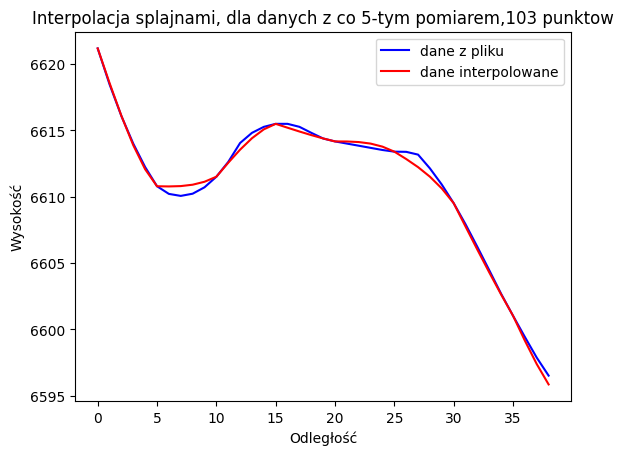

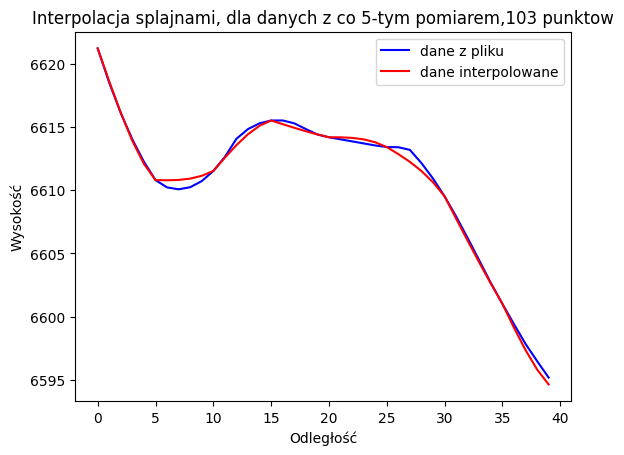

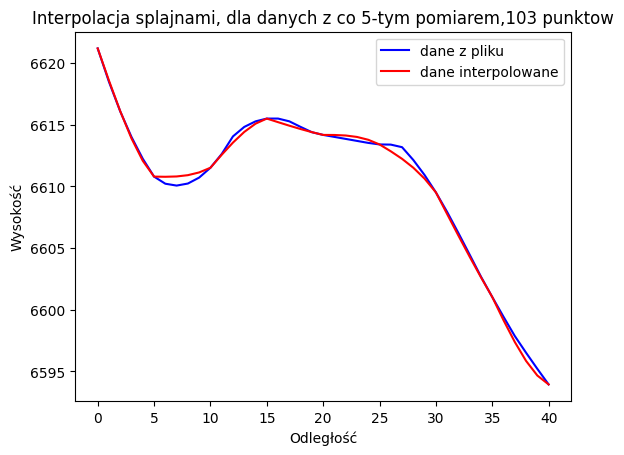

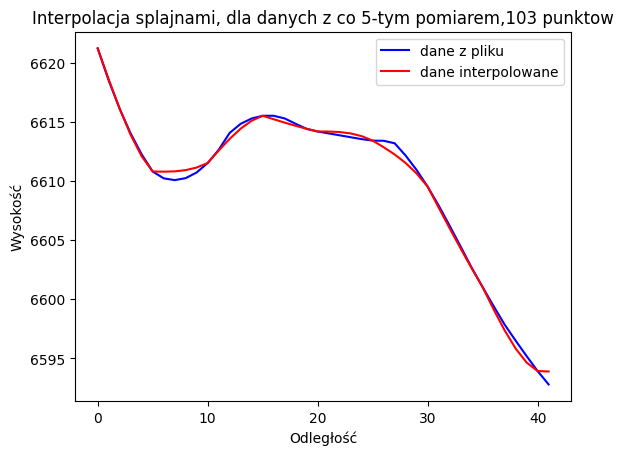

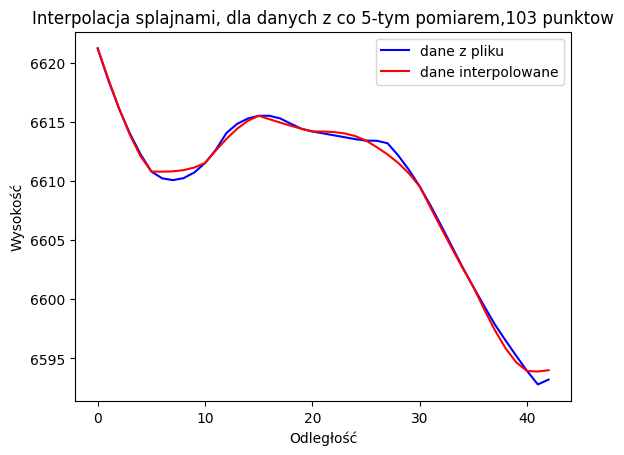

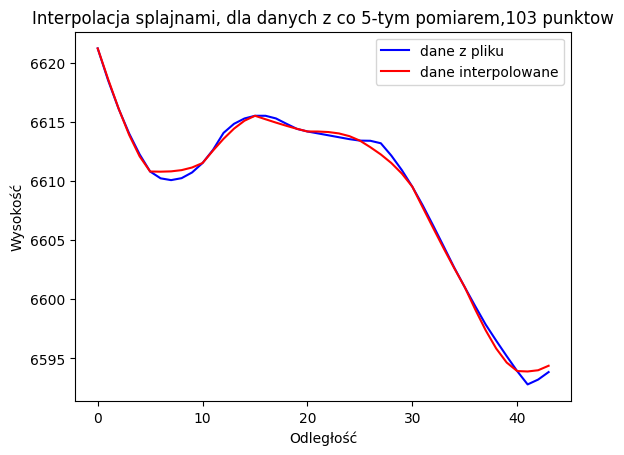

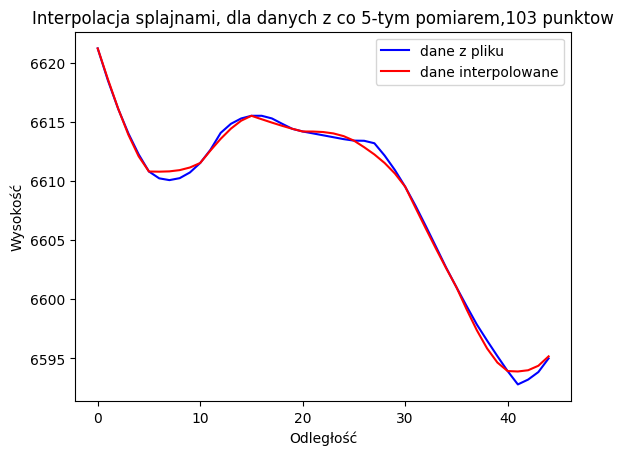

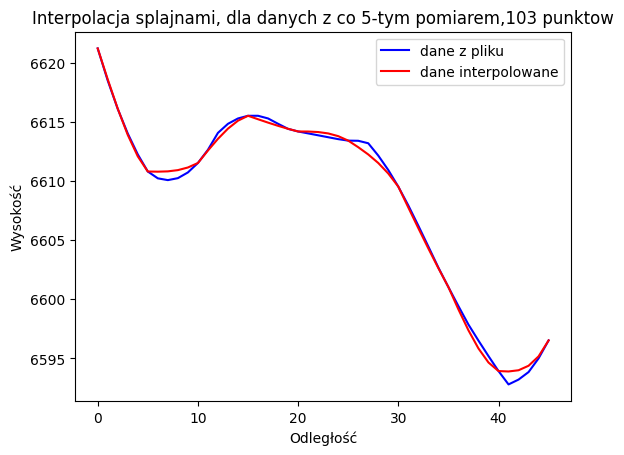

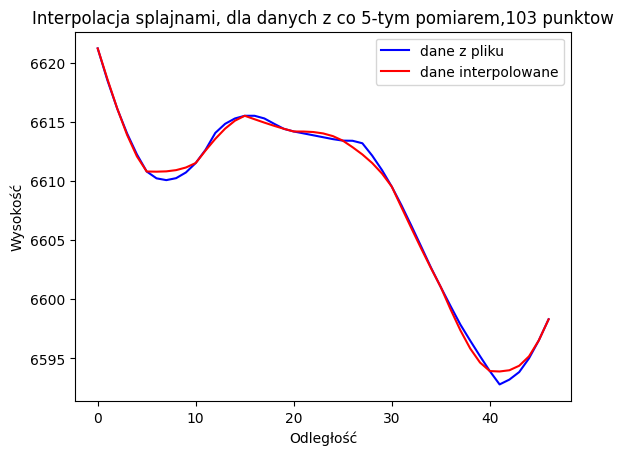

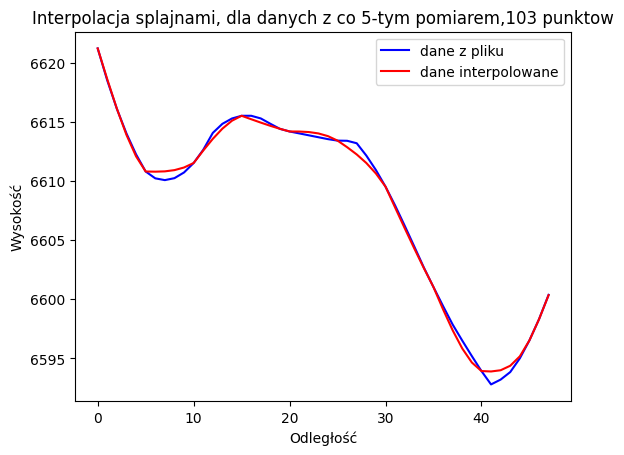

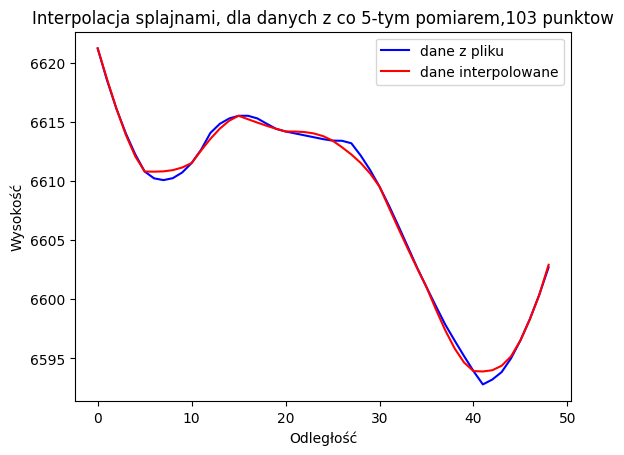

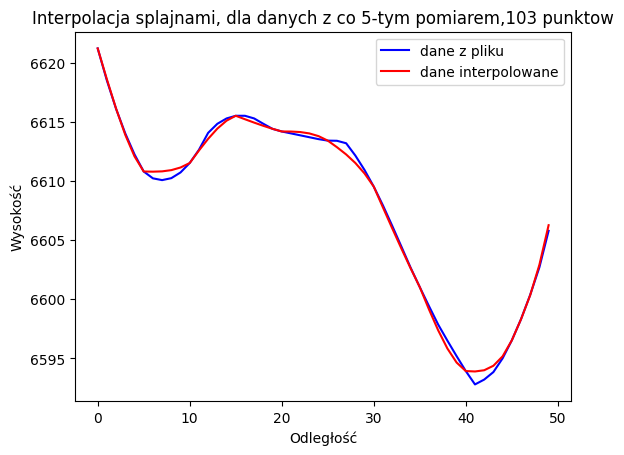

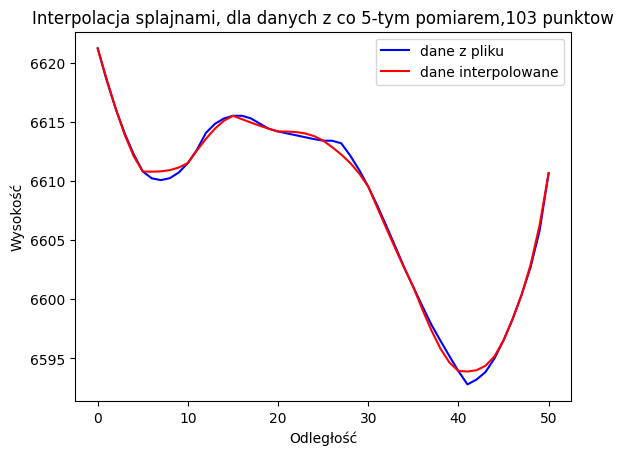

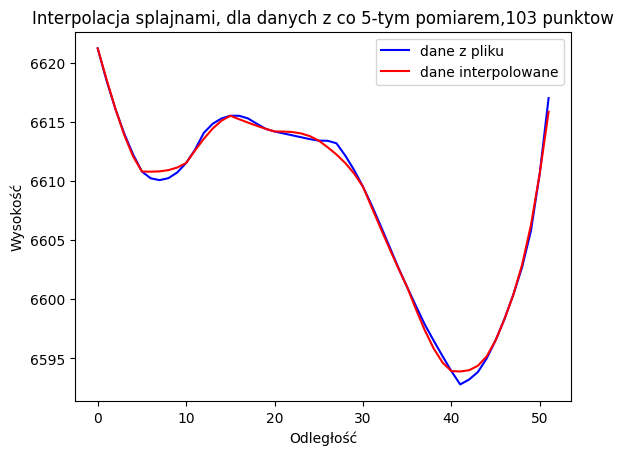

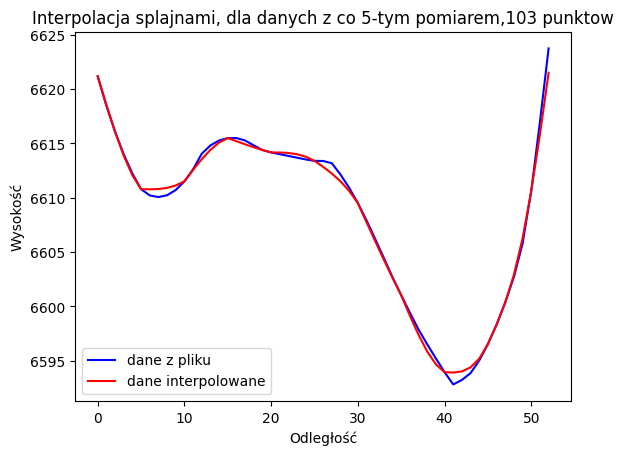

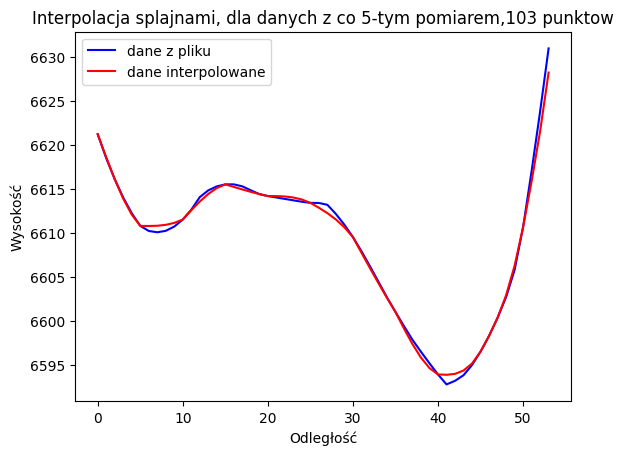

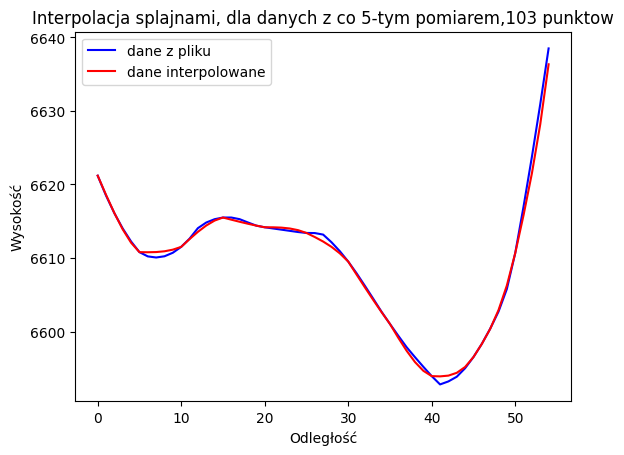

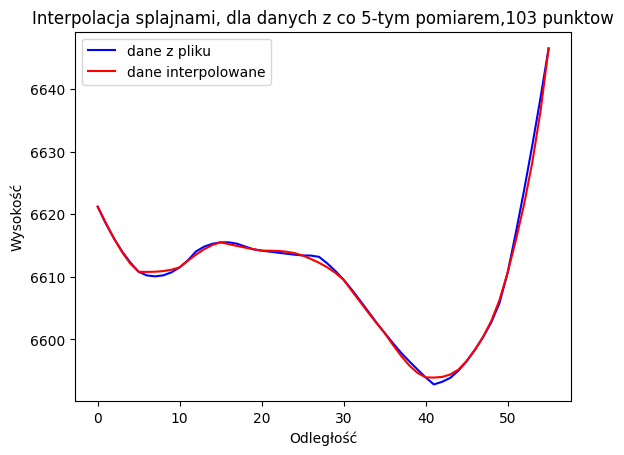

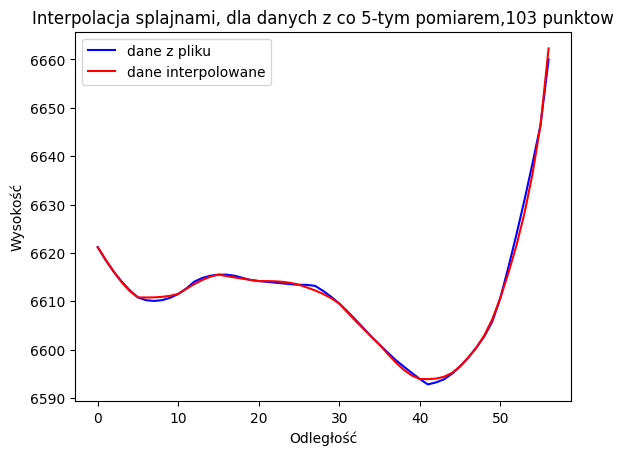

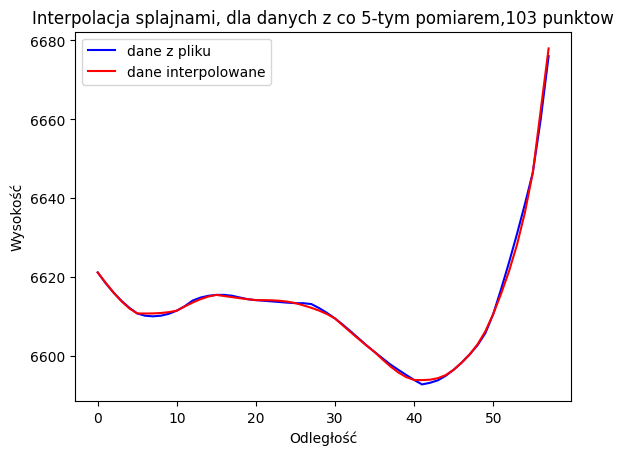

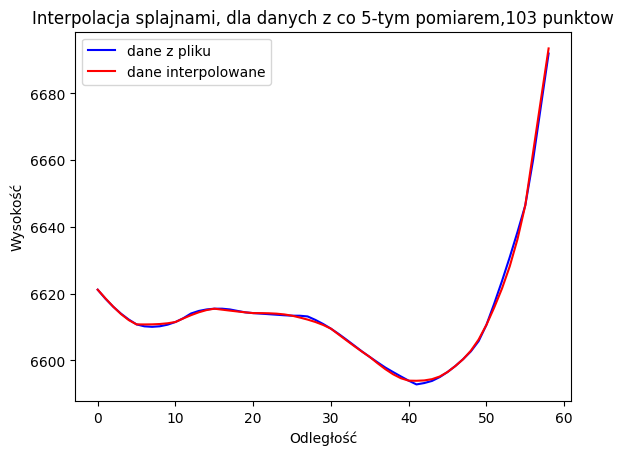

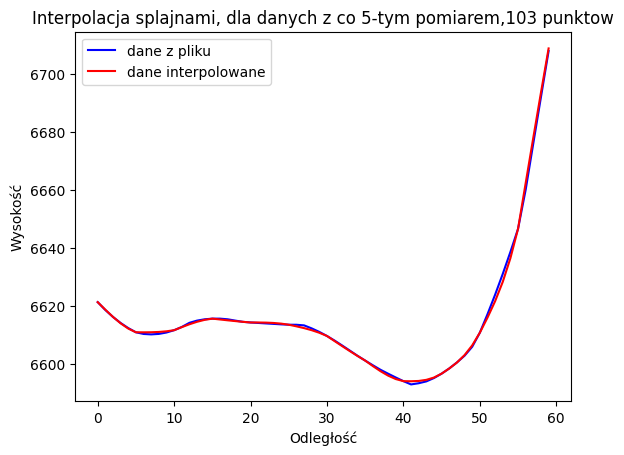

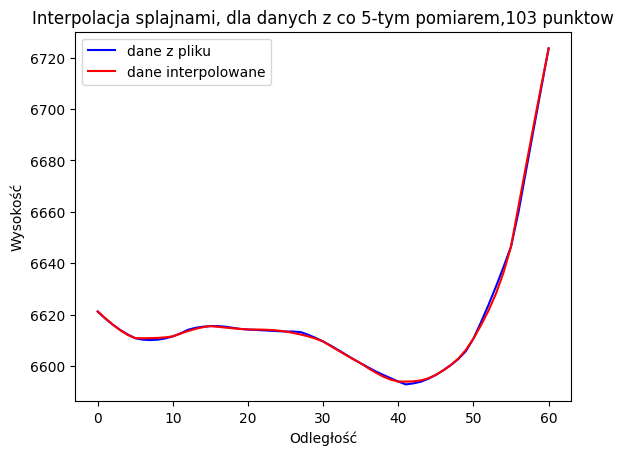

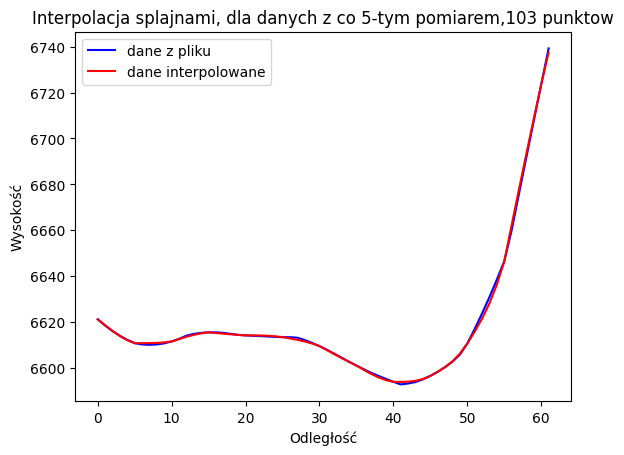

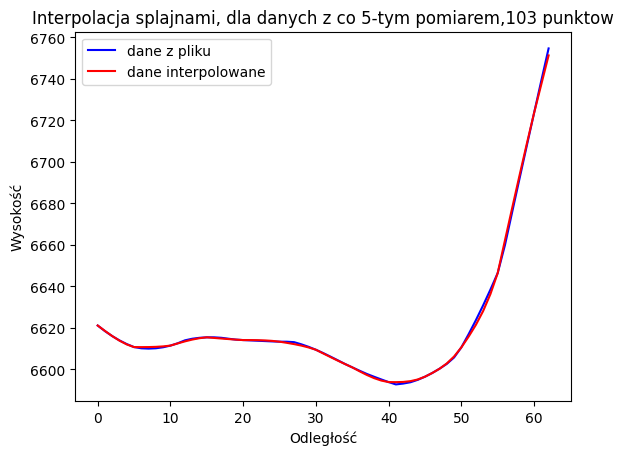

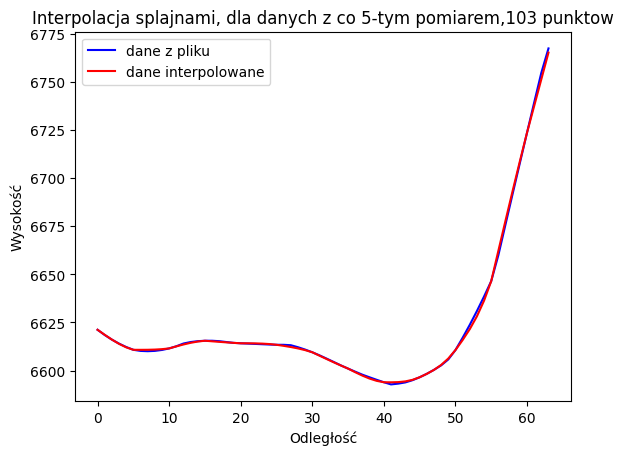

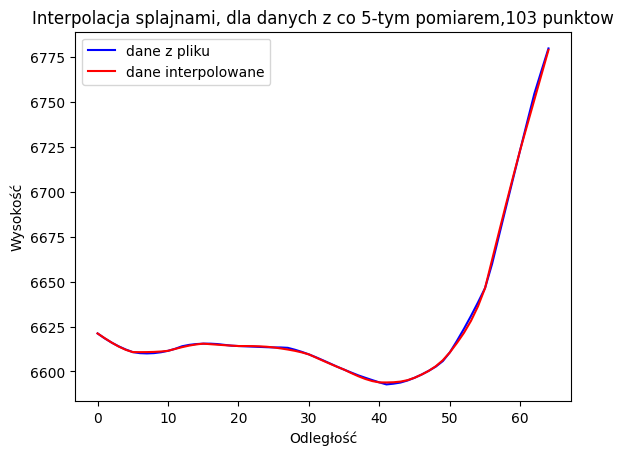

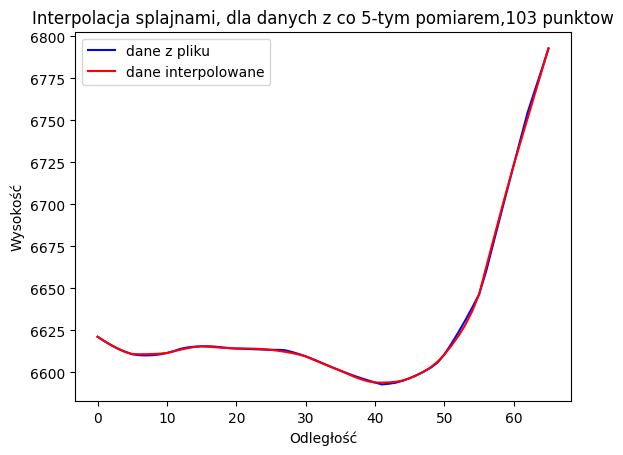

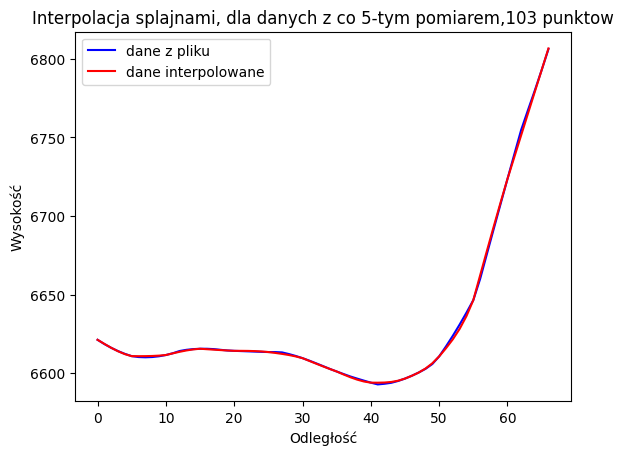

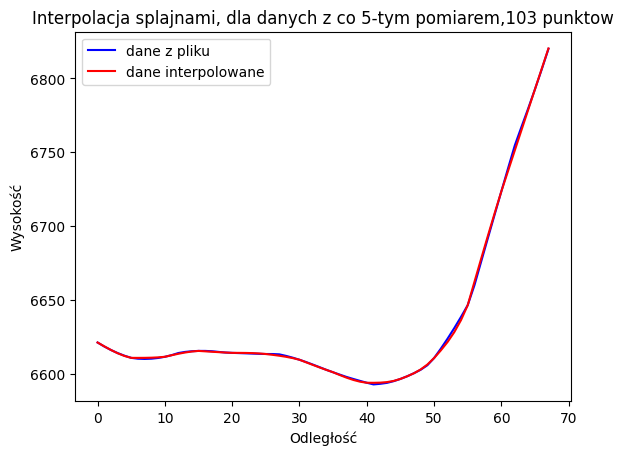

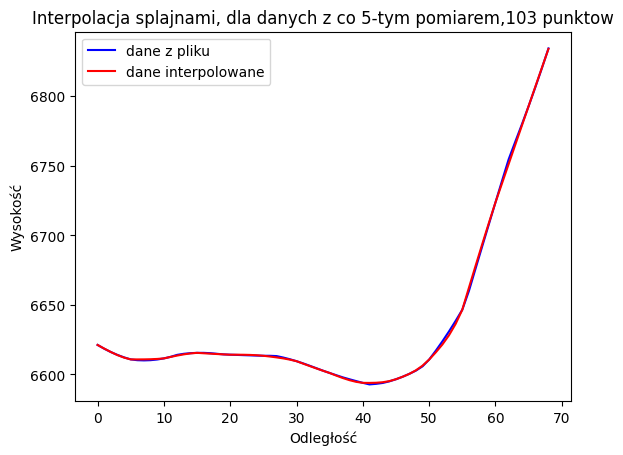

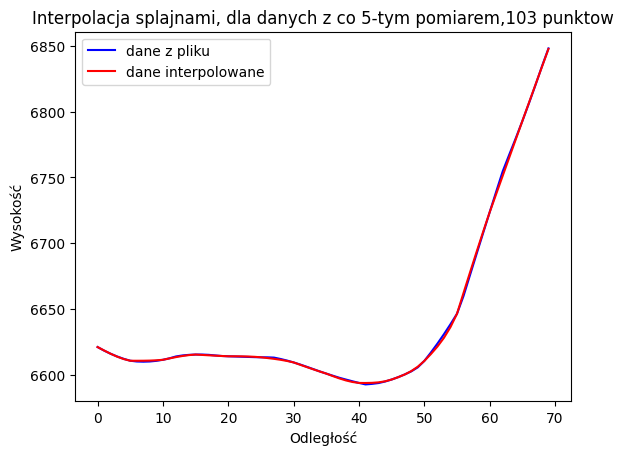

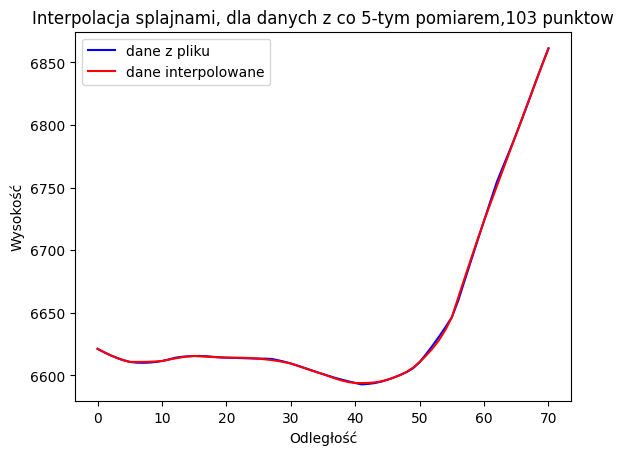

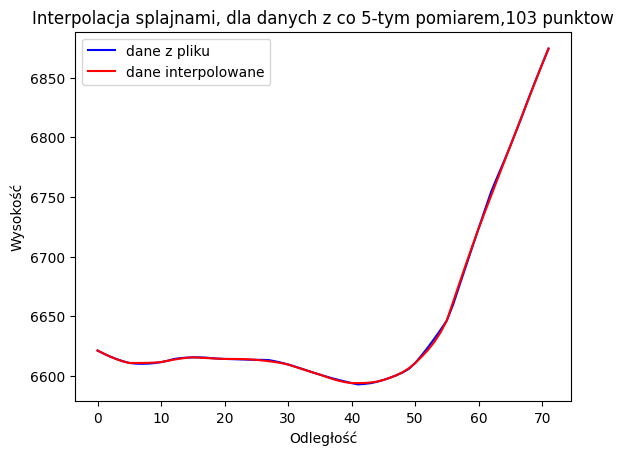

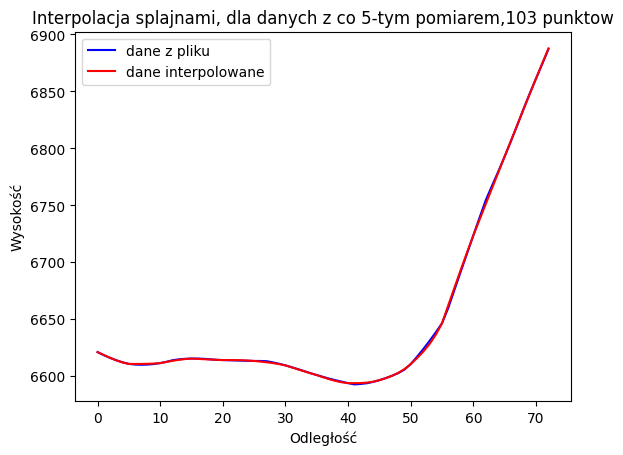

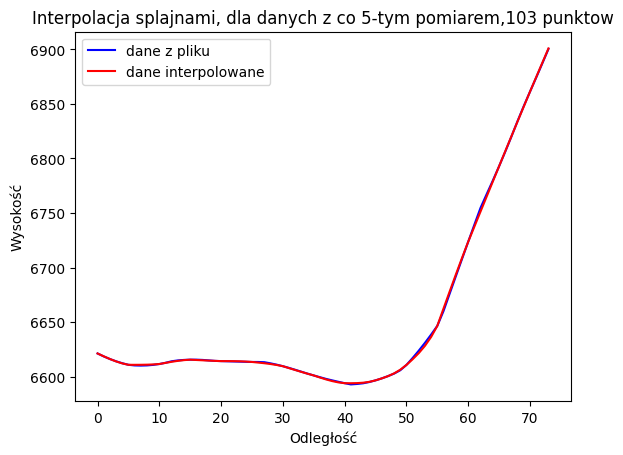

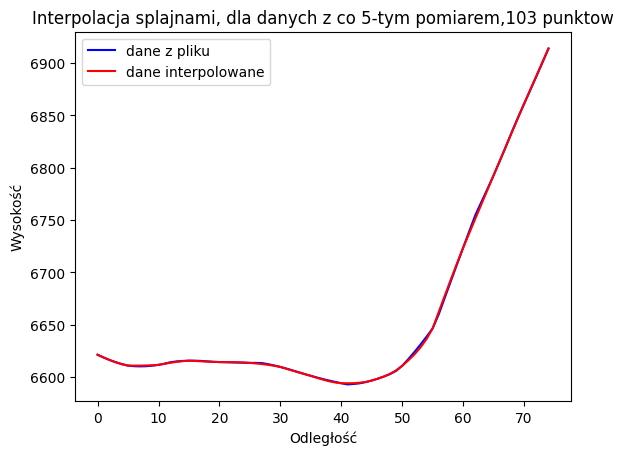

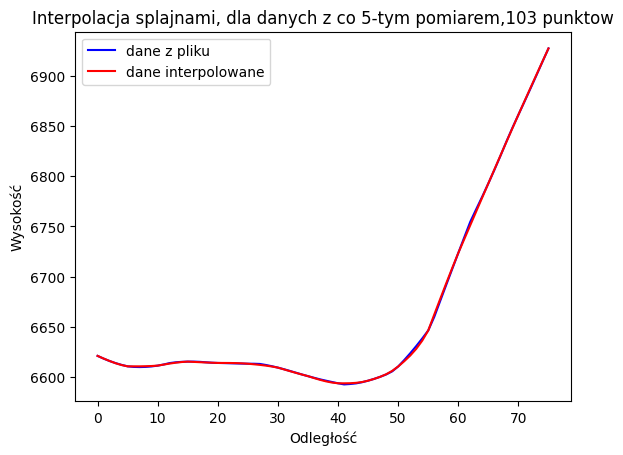

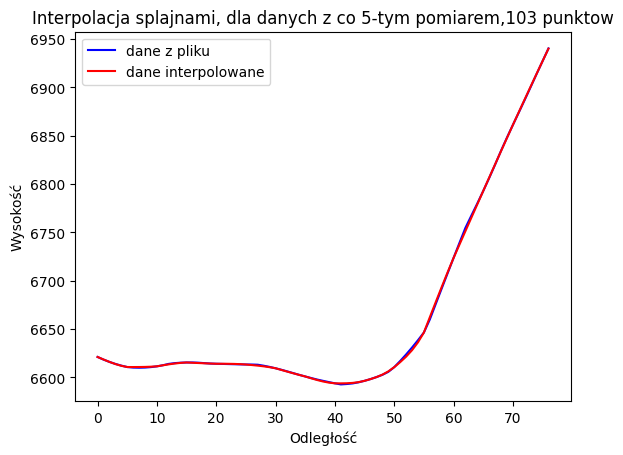

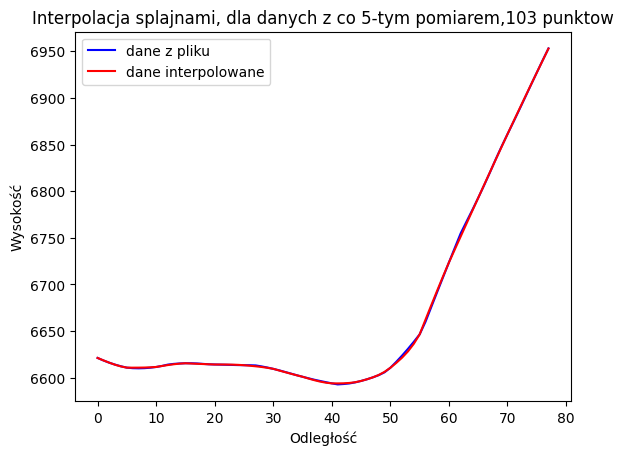

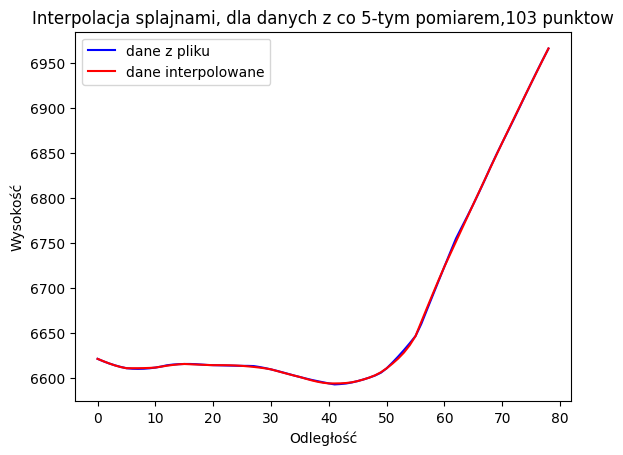

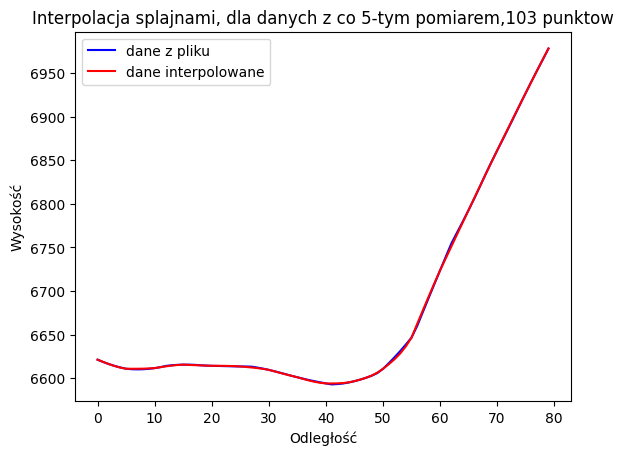

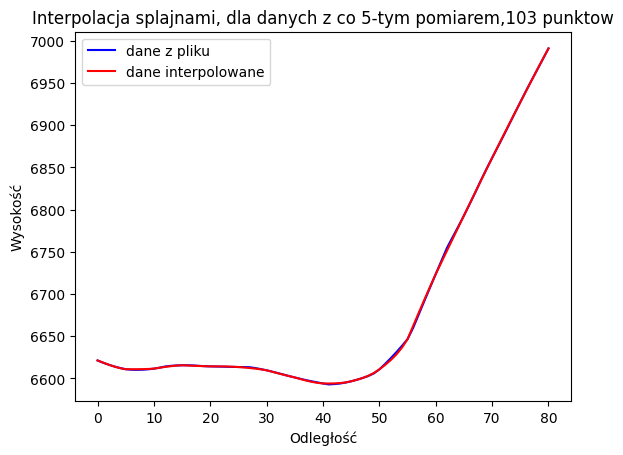

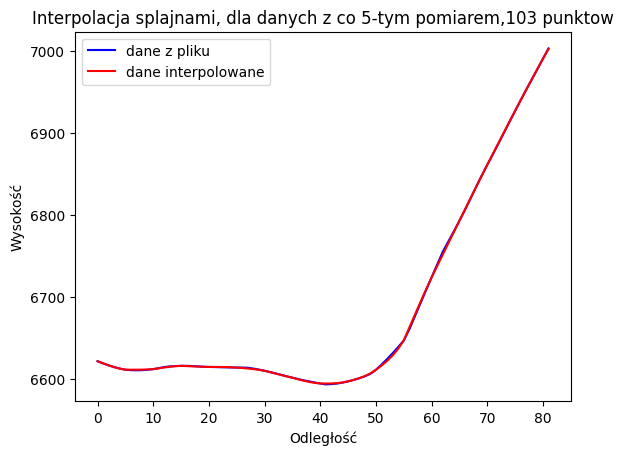

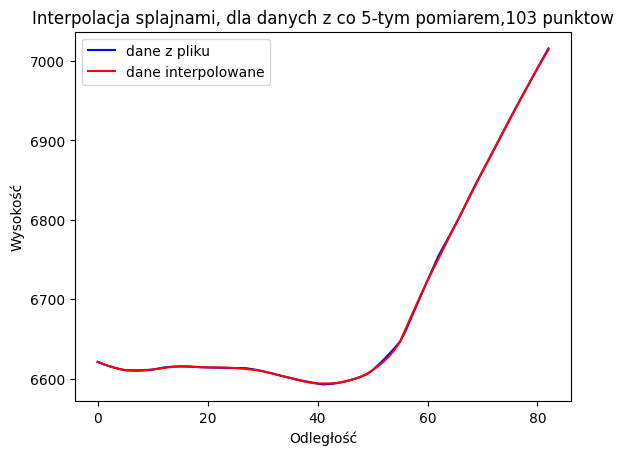

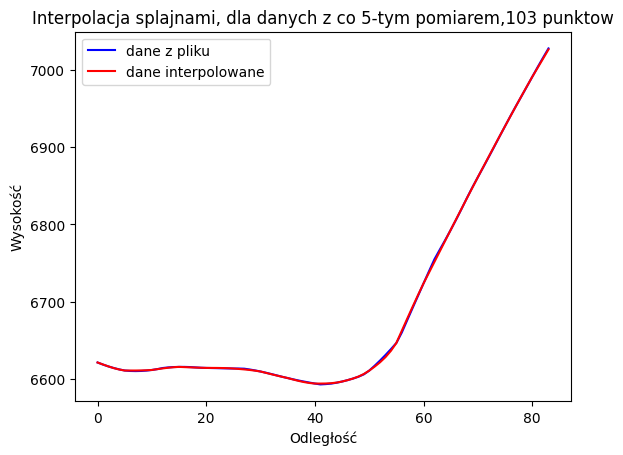

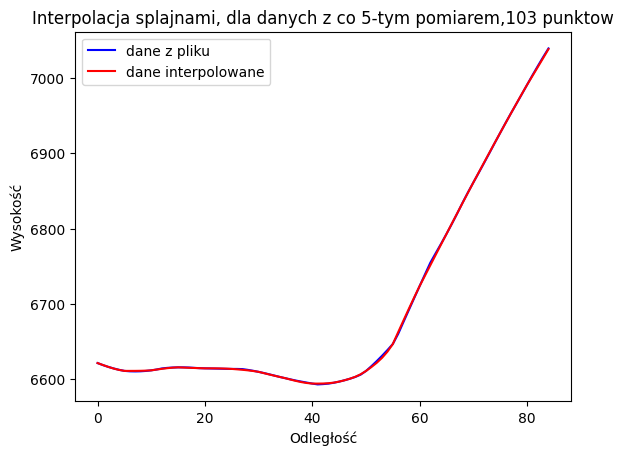

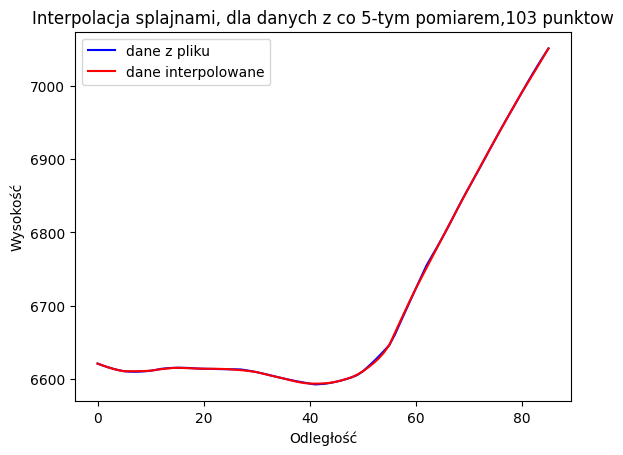

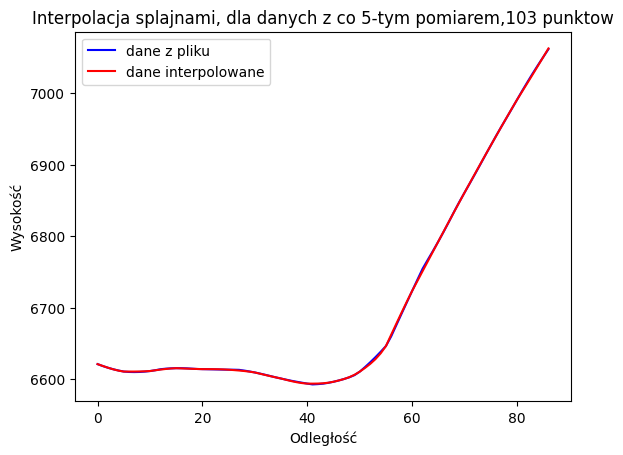

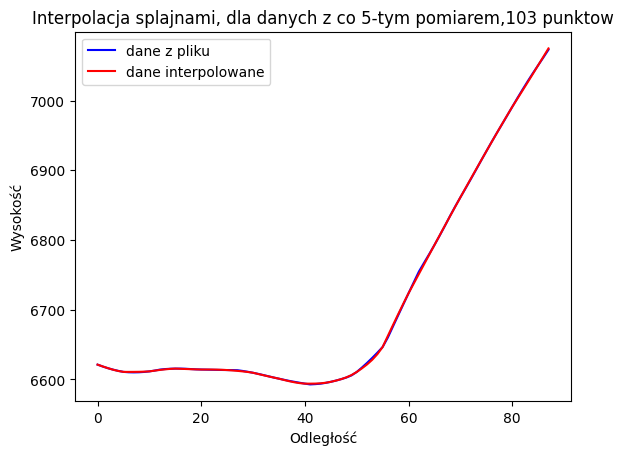

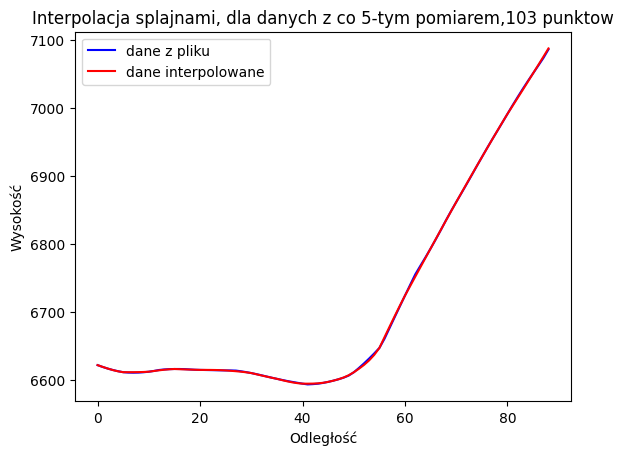

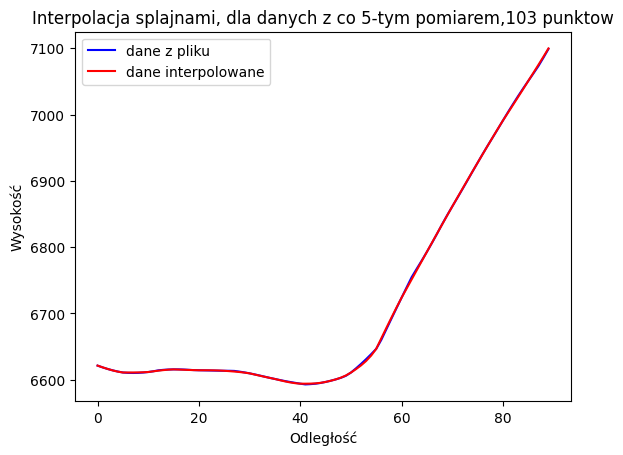

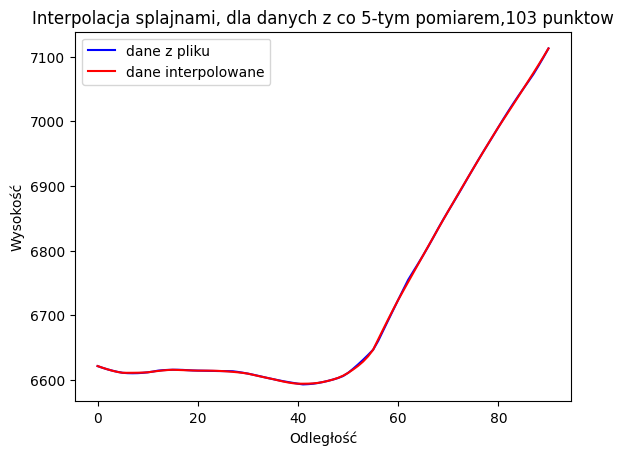

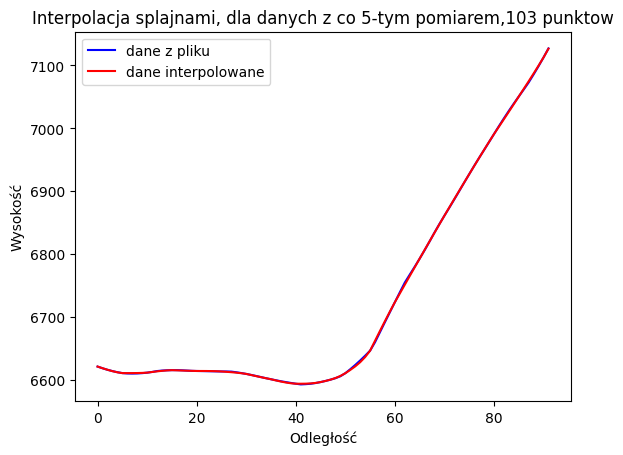

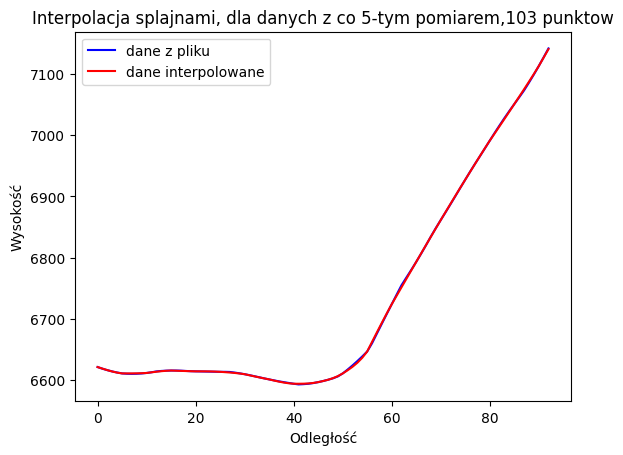

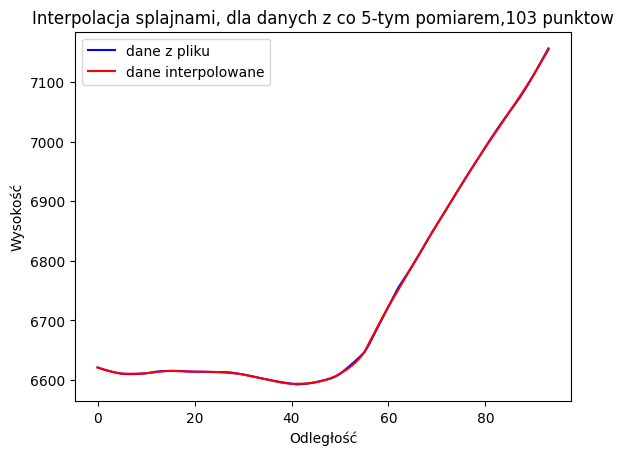

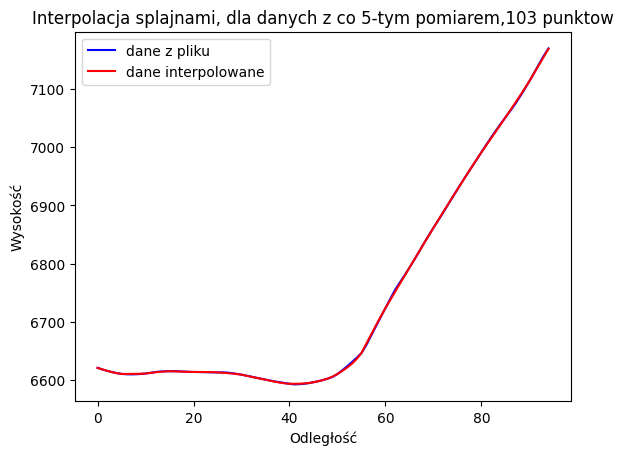

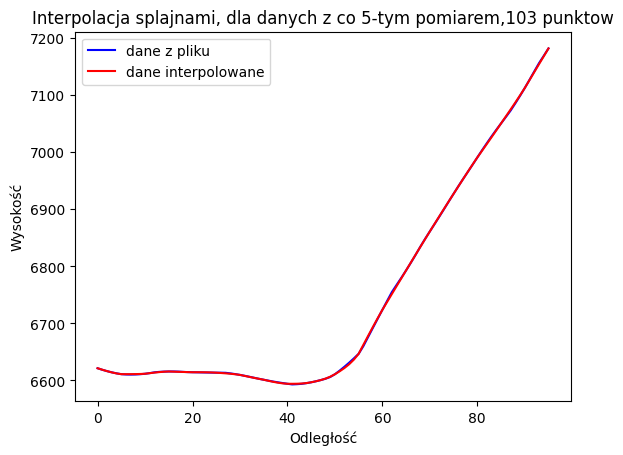

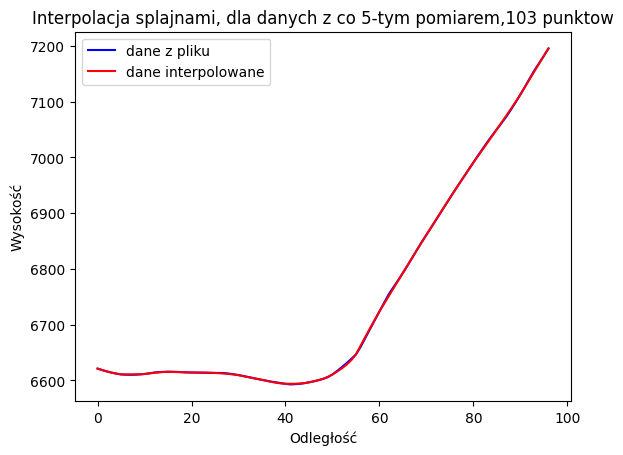

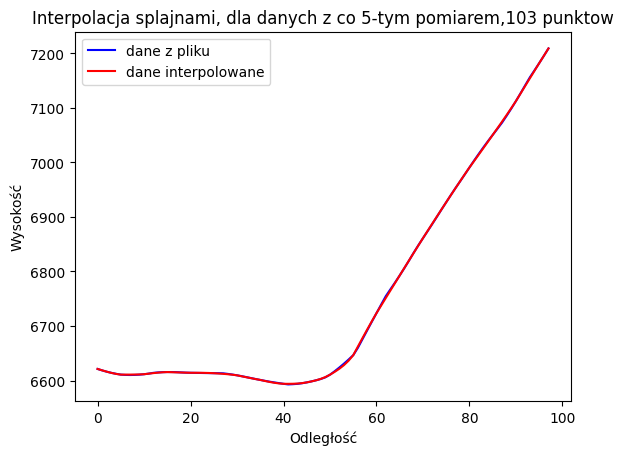

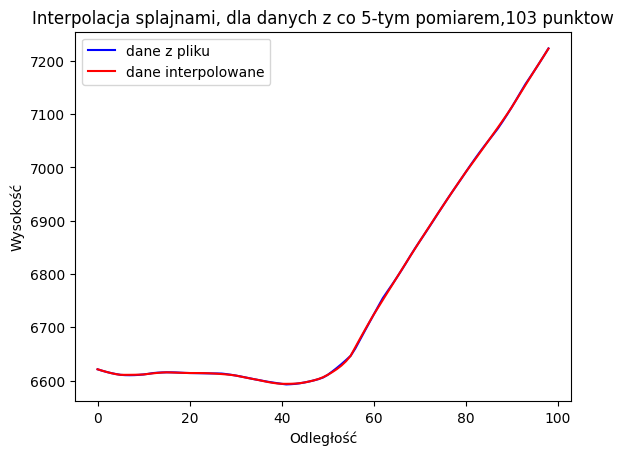

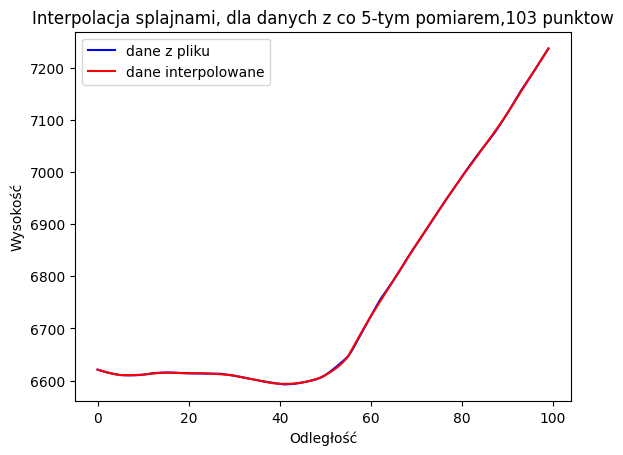

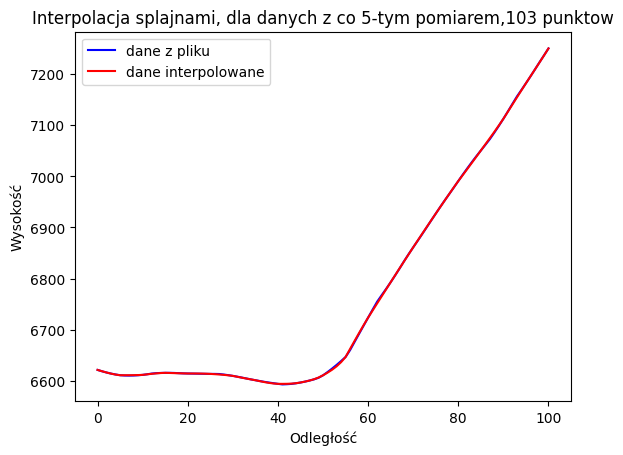

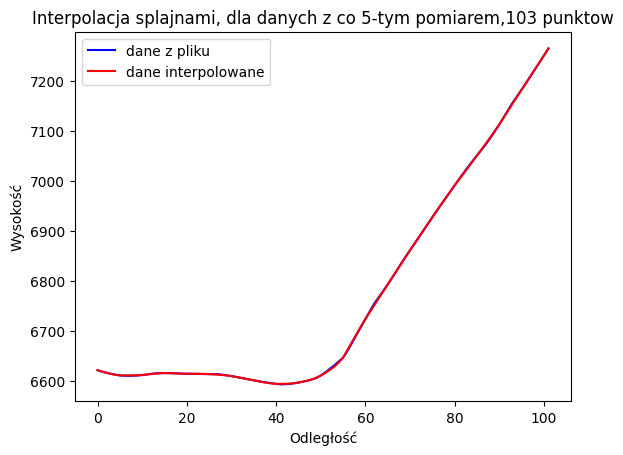

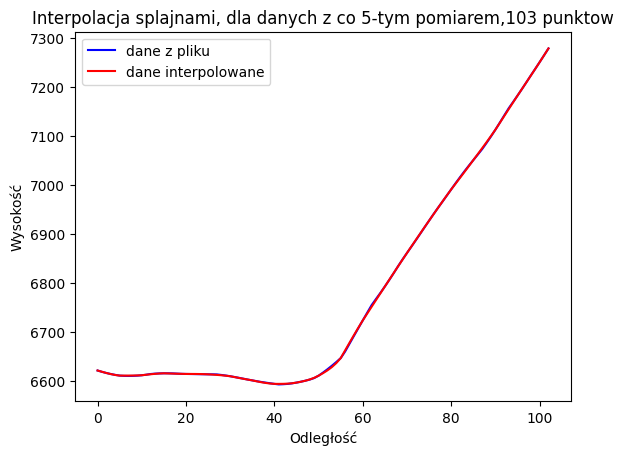

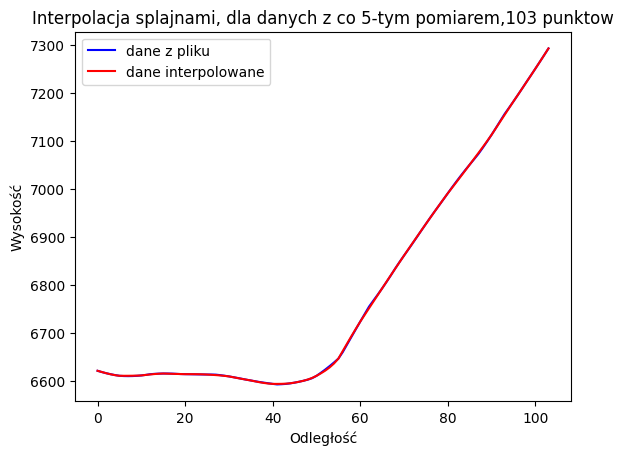

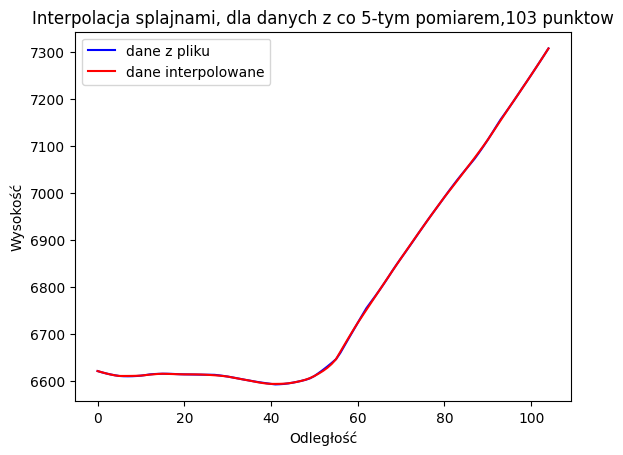

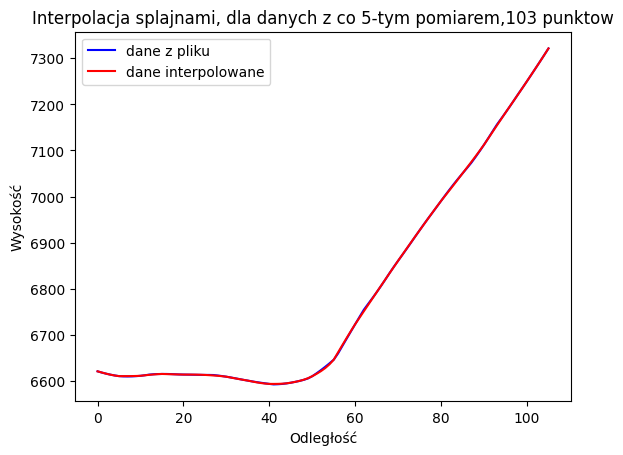

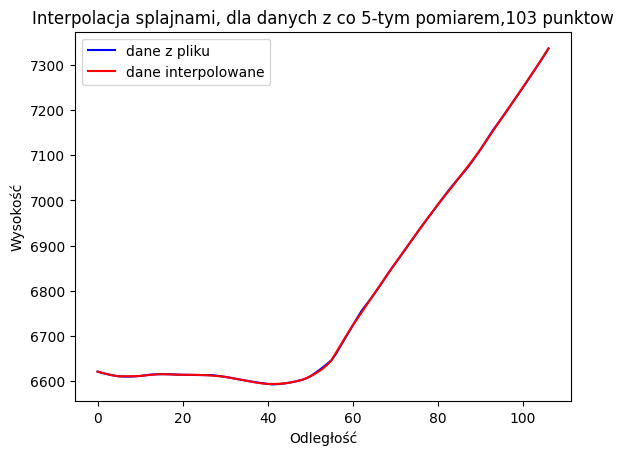

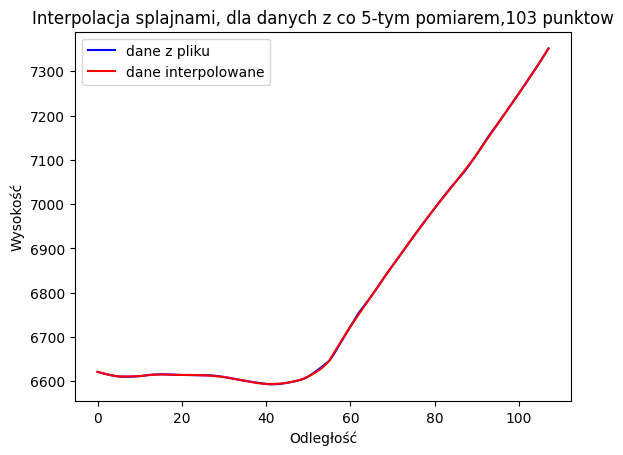

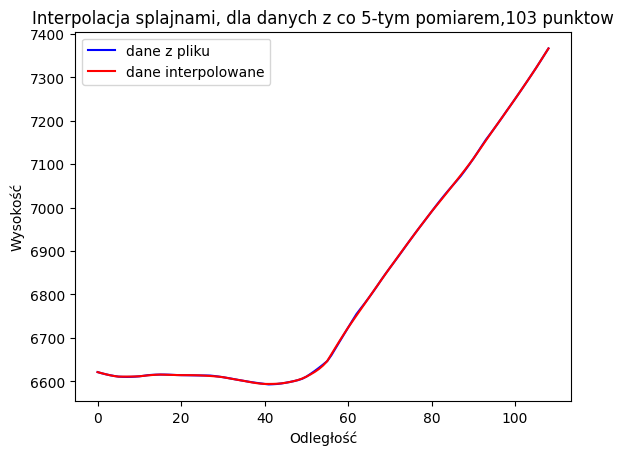

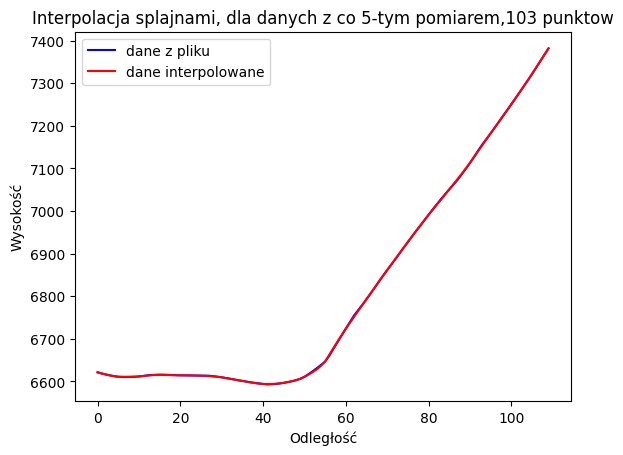

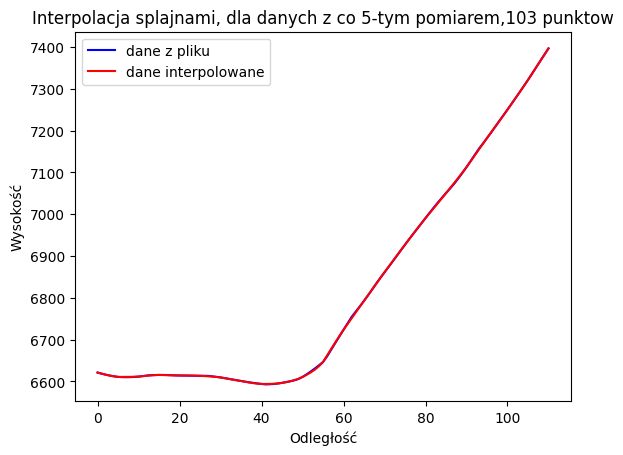

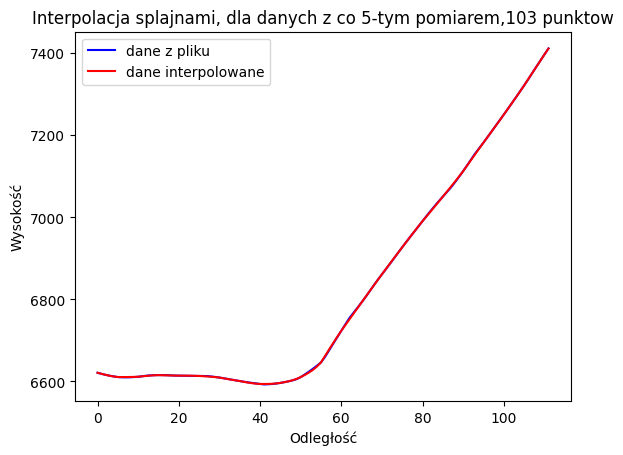

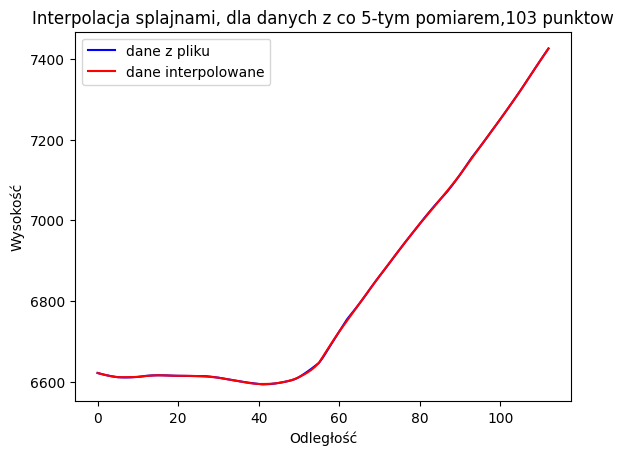

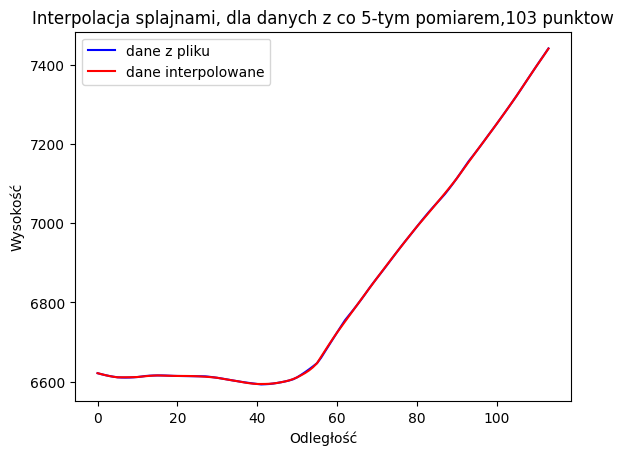

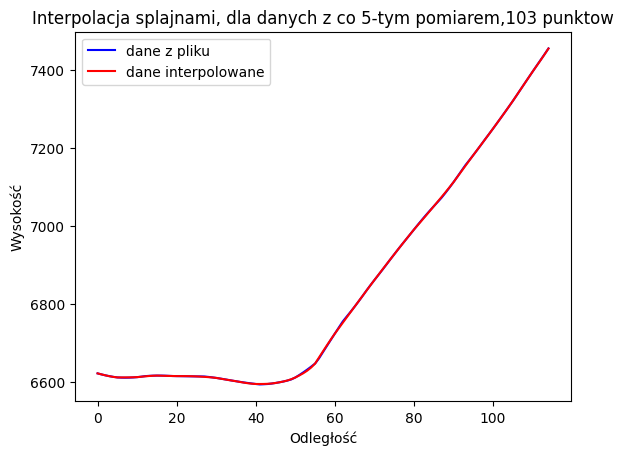

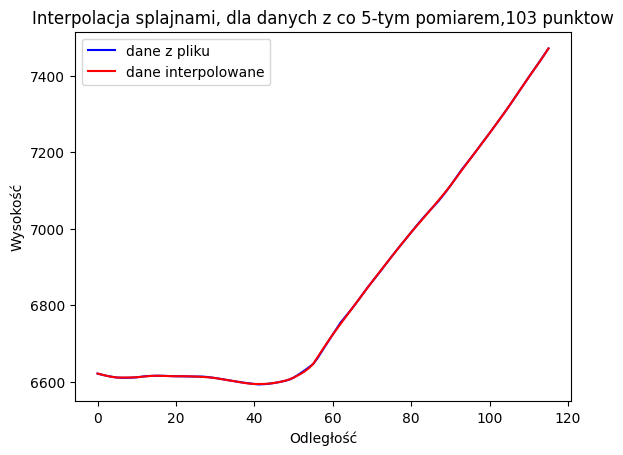

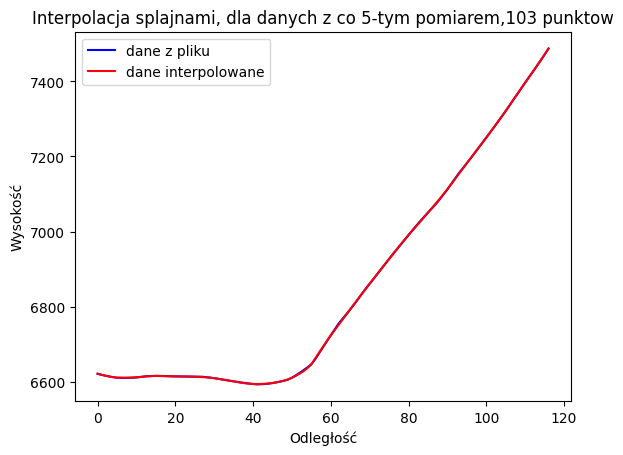

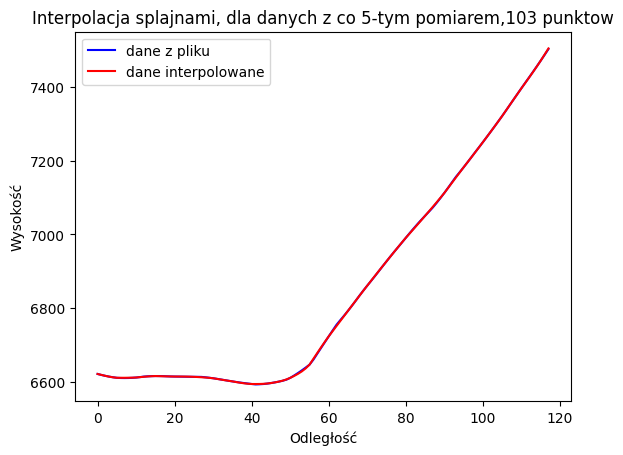

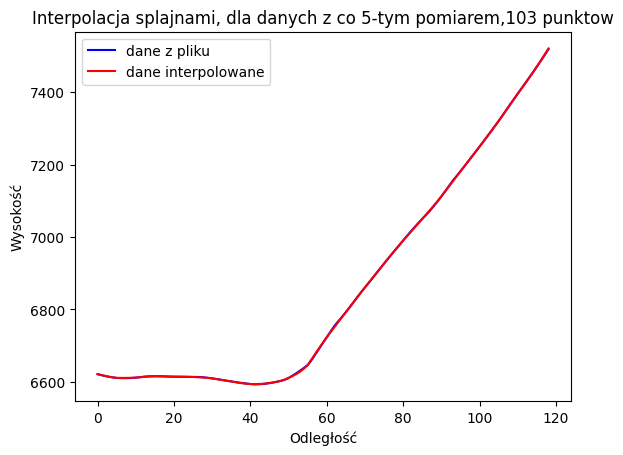

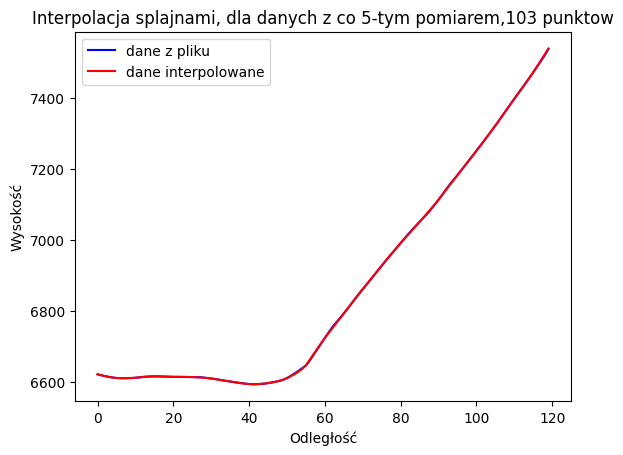

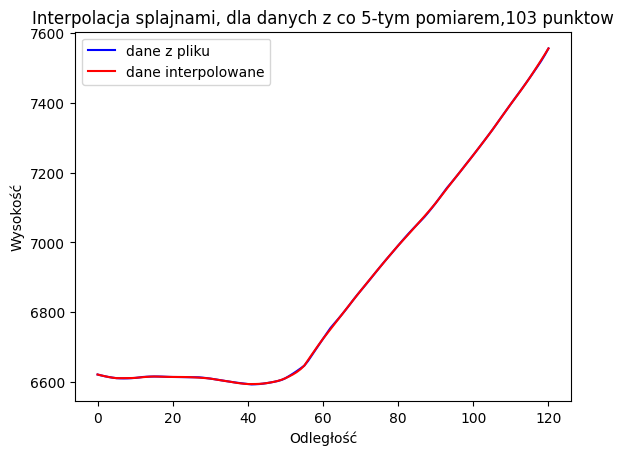

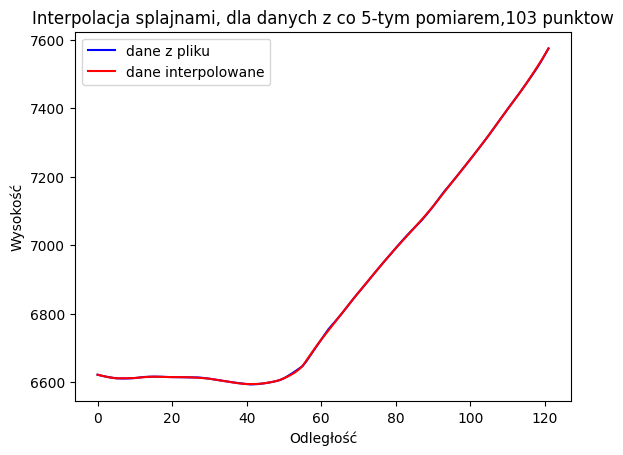

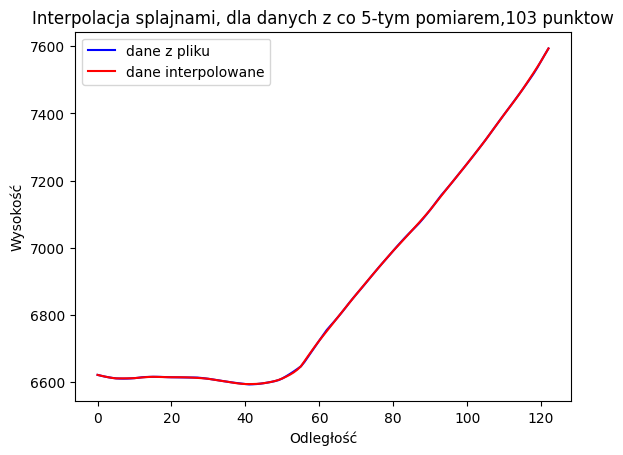

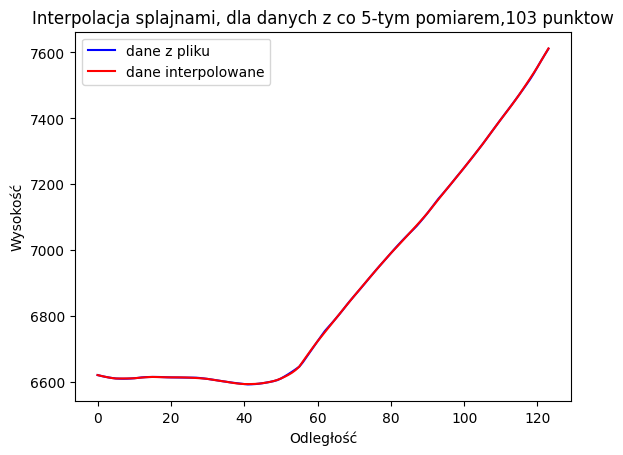

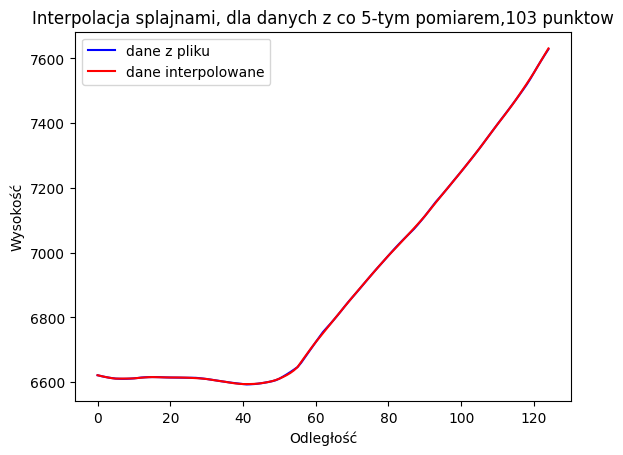

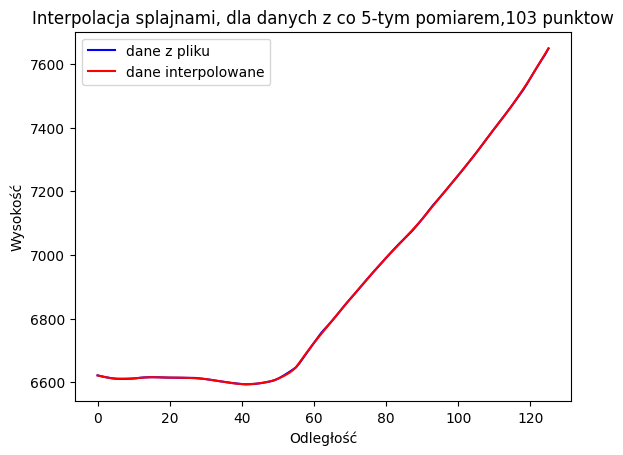

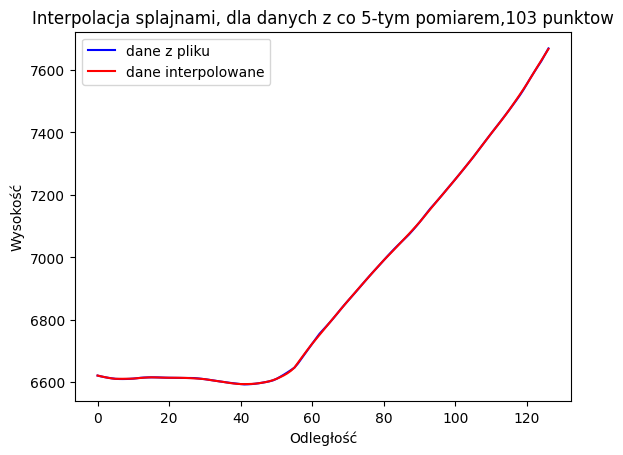

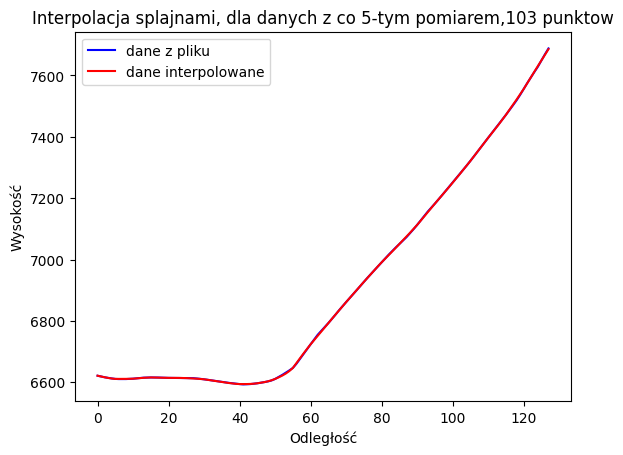

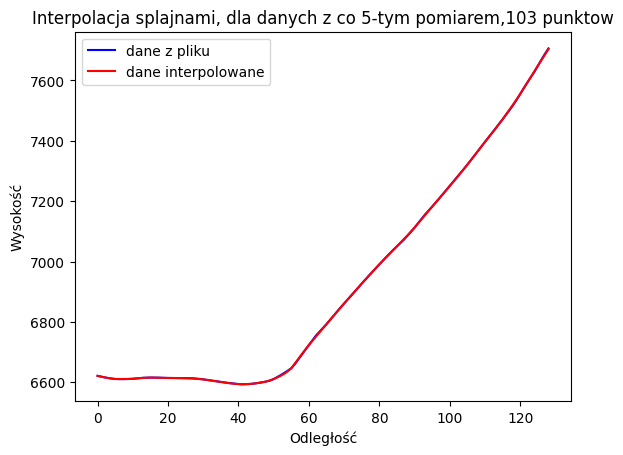

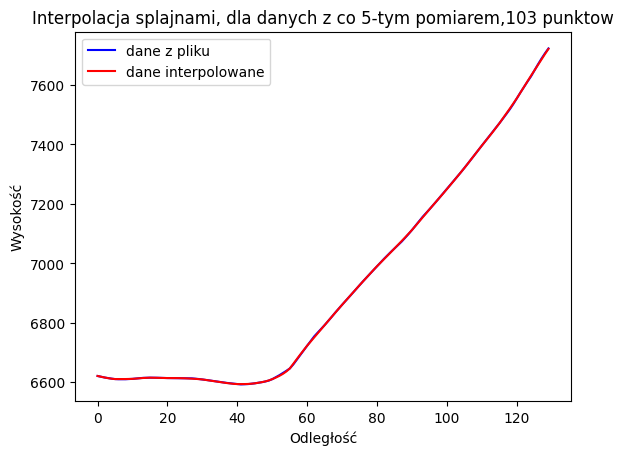

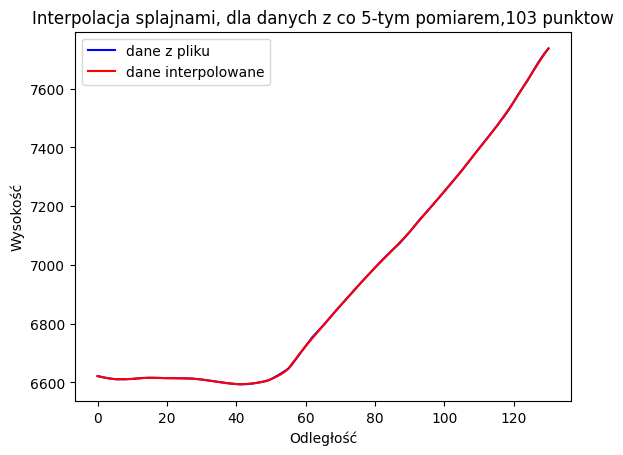

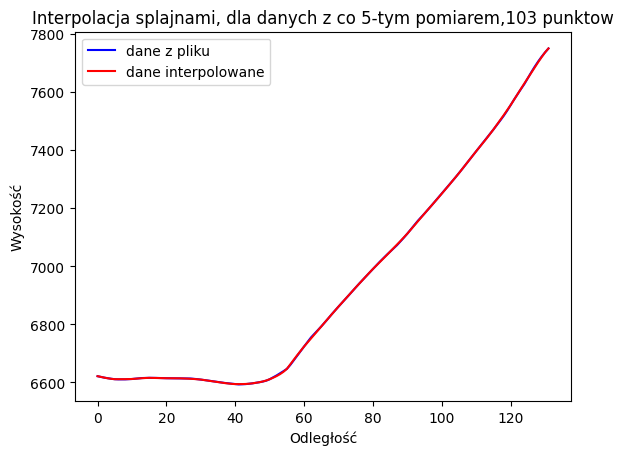

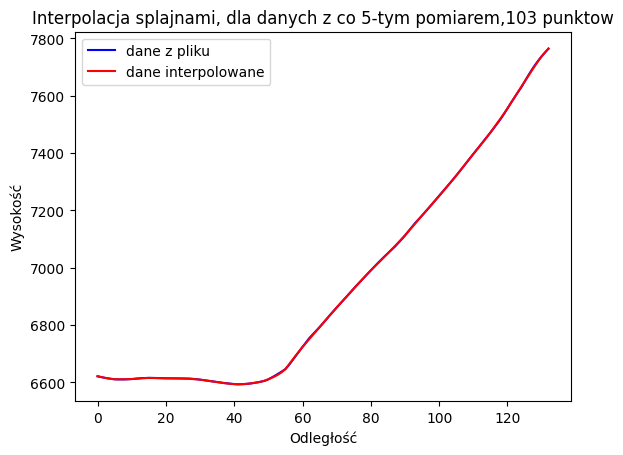

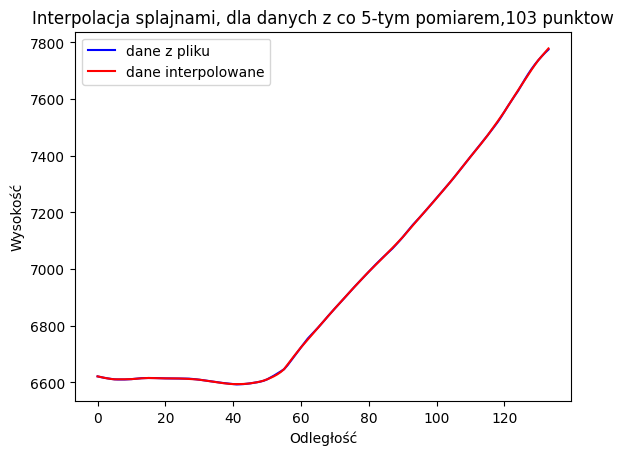

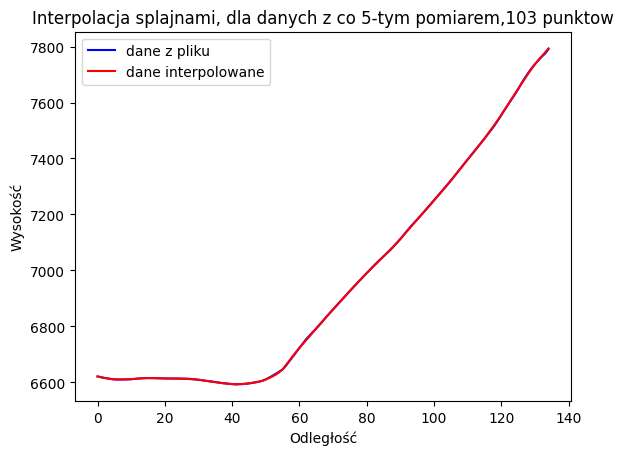

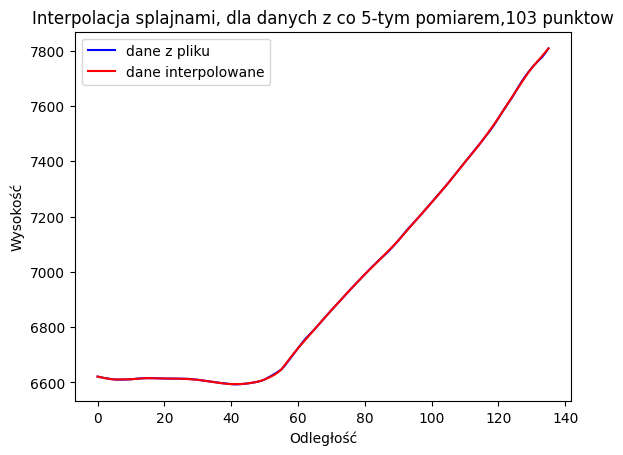

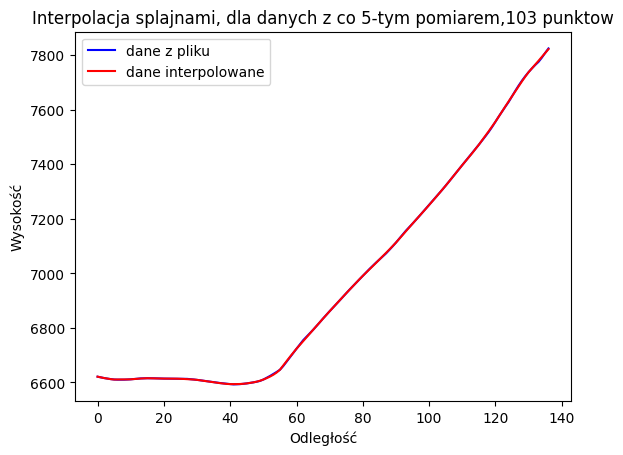

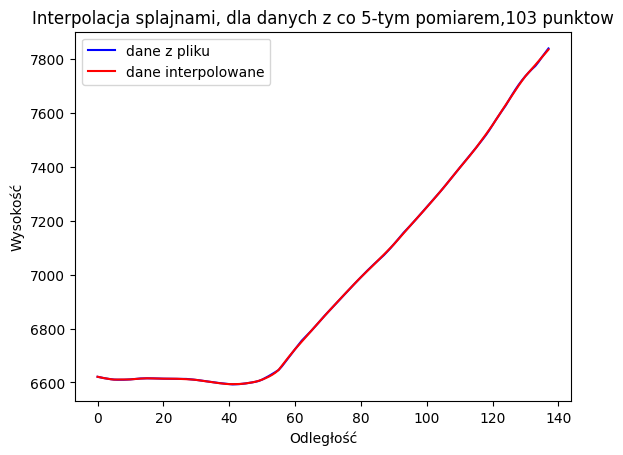

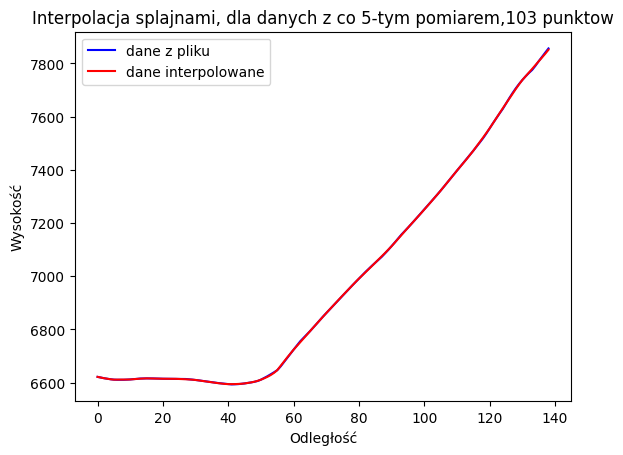

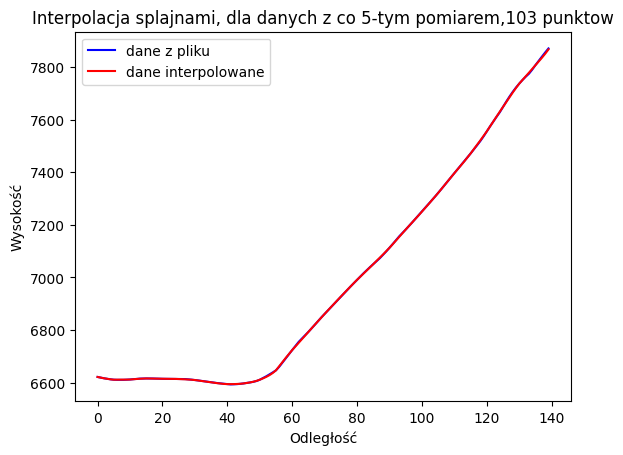

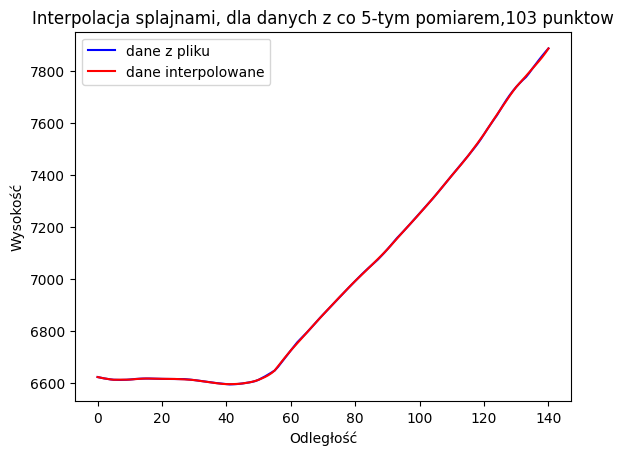

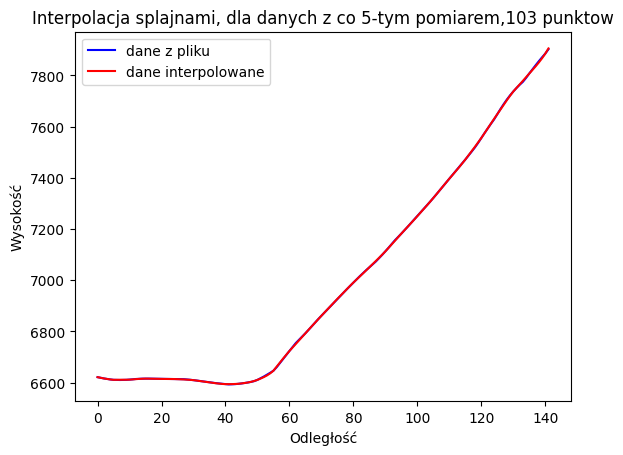

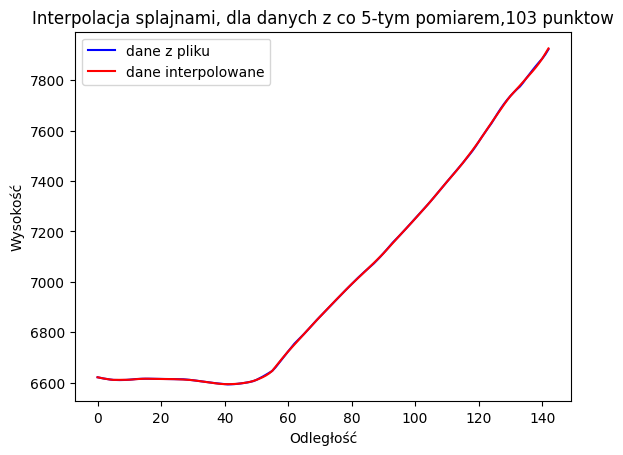

KeyboardInterrupt: ignored

In [39]:
data_to_spline(5)